# **Employee Attrition Analytics**

**Business Problem**

* Problem: perusahaan ingin mengetahui penyebab karyawan melakukan resign dan variabel mana yang perlu segera ditangani
* Objective: membuat model untuk memprediksi penyebab potensial karyawan melakukan resign.
* Success Metric: Attrition Rate (%)
* User: HR analytics team

**Column Description**
- Age = usia
- Attrition = apakah karyawan meninggalkan perusahaan (yes/no)
- Department = divisi dimana karyawan bekerja
- DistanceFromHome = jarak dari rumah karyawan ke tempat kerja
- Education = tingkat pendidikan karyawan (1:SMA, 2:diploma, 3:sarjana, 4:master, 5:doctor)
- EducationField = bidang studi yang diambil karyawan dalam proses pendidikan mereka
- Gender = jenis kelamin
- JobLevel = tingkat jabatan dalam struktur organisasi perusahaan
- JobRole =  jabatan spesifik yang dipegang karyawan dalam perusahaan
- MaritalStatus = status pernikahan
- MonthlyIncome = pendapatan bulanan yang diterima karyawan
- NumCompaniesWorked = jumlah perusahaan yang pernah dipekerjakan karyawan sebelumnya sebelum saat ini
- Over18 = apakah karyawan telah berusia di atas 18 tahun atau tidak
- PercentSalaryHike = persentase kenaikan gaji karyawan dari tahun sebelumnya ke tahun saat ini
- StandardHours =  jumlah jam kerja standar
- StockOptionLevel = tingkat pemberian opsi saham kepada seorang karyawan dalam perusahaan tertentu
- TotalWorkingYears = total jumlah tahun pengalaman kerja yang dimiliki oleh seorang karyawan
- TrainingTimesLastYear = waktu pelatihan yang diikuti oleh seorang karyawan dalam satu tahun terakhir sebelum saat ini
- YearsAtCompany = total jumlah tahun yang telah dihabiskan oleh seorang karyawan di perusahaan
- YearsSinceLastPromotion = jumlah tahun yang telah berlalu sejak seorang karyawan terakhir kali dipromosikan di perusahaan tersebut
- YearsWithCurrManager =  jumlah tahun yang telah dihabiskan oleh seorang karyawan bekerja di bawah manajer saat ini
- EnvironmentSatisfaction = tingkat kepuasan atau kepuasan subjektif seorang karyawan terhadap lingkungan kerja
- JobSatisfaction = tingkat kepuasan subjektif seorang karyawan terhadap pekerjaan mereka
- WorkLifeBalance = tingkat keseimbangan antara kehidupan kerja dan kehidupan pribadi seorang karyawan
- JobInvolvement = tingkat keterlibatan seorang karyawan terhadap pekerjaan mereka
- PerformanceRating = penilaian atau peringkat kinerja seorang karyawan dalam perusahaan

In [ ]:
pip install shap

**Import Library**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# feature importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# helper function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
import time

# modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost
import shap

import warnings
warnings.filterwarnings("ignore")

## **1. Load Dataset**

In [ ]:
employee_survey = pd.read_csv('employee_survey_data.csv')
manager_survey = pd.read_csv('manager_survey_data.csv')
general = pd.read_csv('general_data.csv')

# join dataset
df = general.join([employee_survey.drop('EmployeeID',axis=1),
                   manager_survey.drop('EmployeeID',axis=1)])

In [ ]:
df.head()

Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   TotalWorkingYears TrainingTimesLastYear YearsAtCompany  \
0                1.0                     6              1   
1                6.0                     3              5   
2                5.0                     2              5   
3               13.0                     5              8   
4                9.0                     2              6   

   YearsSinceLastPromotion  YearsWithCurrManager EnvironmentSatisfaction  \
0                        0                     0                     3.0   
1                        1                     4                     3.0   
2                        0                     3                     2.0   
3                        7                     5                     4.0   
4                        0                     4                     4.0   

   JobSatisfaction  WorkLifeBalance  JobInvolvement  PerformanceRating  
0              4.0              2.0               3                  3  
1              2.0              4.0               2                  4  
2              2.0              1.0               3                  3  
3              4.0              3.0               2                  3  
4              1.0              3.0               3                  3  

[5 rows x 29 columns]

In [ ]:
df_raw = df.copy()

## **2. EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Data terdiri dari 4410 baris, 29 kolom, dan memiliki missing value.

Tipe data kurang sesuai:
- Education
- JobLevel
- StockOptionLevel
- EnvironmentSatisfaction
- JobInvolvement
- JobSatisfaction
- PerformanceRating
- WorkLifeBalance

In [ ]:
# kolom yg akan diubah menjadi string
kolom_to_string = ['Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction',
                   'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'WorkLifeBalance']

# mengubah kolom int menjadi str
for col in kolom_to_string:
    df[col] = df[col].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   object 
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   object 
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### **Univariate Analysis**

In [ ]:
# 1. TotalWorkingYears
df['TotalWorkingYears_Category'] = pd.cut(df['TotalWorkingYears'], bins=[0, 3, 10, 40], labels=['Entry Level', 'Medium Level', 'Senior Level'])

# 2. Age
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 100], labels=['Young', 'Middle', 'Senior', 'Elderly'])

category_column = ['TotalWorkingYears_Category', 'Age_Group']
df[category_column] = df[category_column].astype('object')

In [ ]:
# memisahkan kolom numerik dan kategorik
nums = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
        'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
        'YearsWithCurrManager']
cats = ['Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'Gender',
        'JobLevel', 'JobRole', 'MaritalStatus', 'StockOptionLevel', 'EnvironmentSatisfaction',
        'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating',
        'TotalWorkingYears_Category', 'Age_Group']

kolom `EmployeeCount`, `EmployeeID`, `Over18`, dan `StandardHours` tidak digunakan karena tidak memiliki korelasi untuk analisis

#### **Categoric**

In [ ]:
df[cats].describe()

Attrition BusinessTravel              Department Education  \
count       4410           4410                    4410      4410   
unique         2              3                       3         5   
top           No  Travel_Rarely  Research & Development         3   
freq        3699           3129                    2883      1716   

       EducationField Gender JobLevel          JobRole MaritalStatus  \
count            4410   4410     4410             4410          4410   
unique              6      2        5                9             3   
top     Life Sciences   Male        1  Sales Executive       Married   
freq             1818   2646     1629              978          2019   

       StockOptionLevel EnvironmentSatisfaction JobSatisfaction  \
count              4410                    4410            4410   
unique                4                       5               5   
top                   0                     3.0             4.0   
freq               1893                    1350            1367   

       WorkLifeBalance JobInvolvement PerformanceRating  \
count             4410           4410              4410   
unique               5              4                 2   
top                3.0              3                 3   
freq              2660           2604              3732   

       TotalWorkingYears_Category Age_Group  
count                        4368      4410  
unique                          3         4  
top                  Medium Level    Middle  
freq                         2270      1857

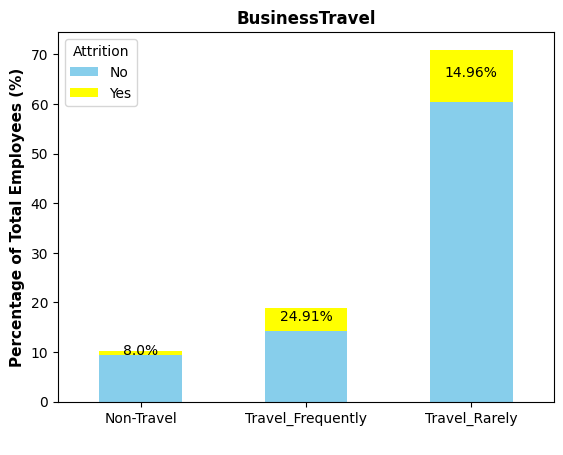

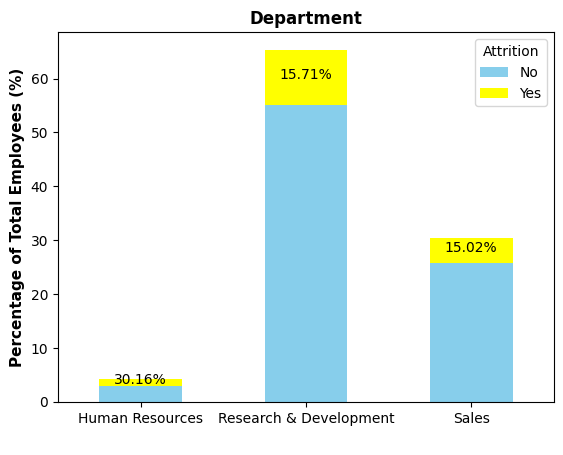

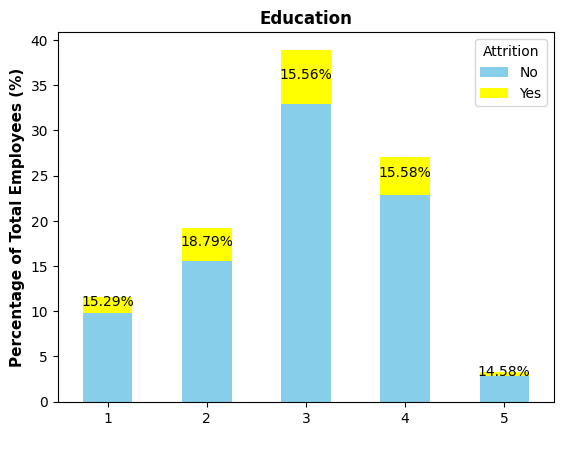

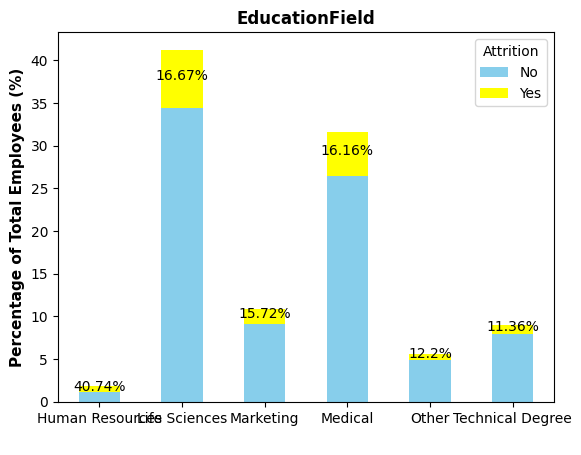

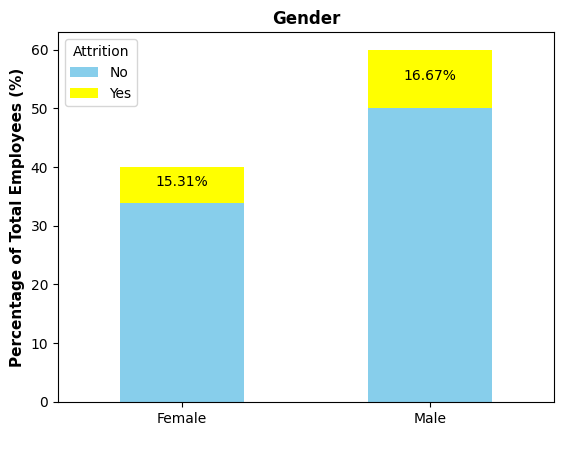

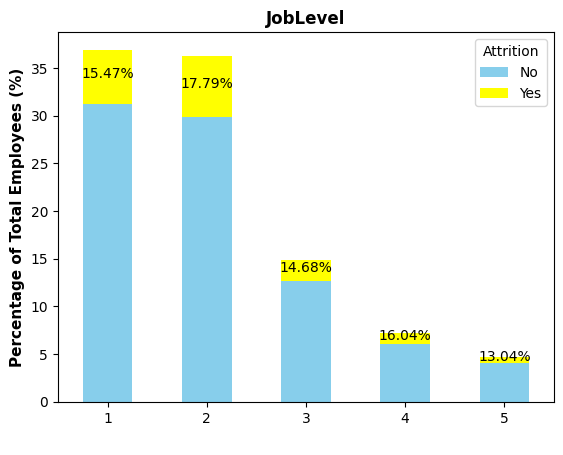

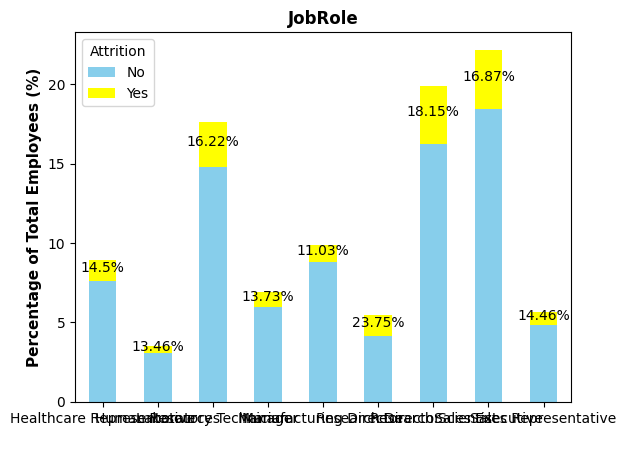

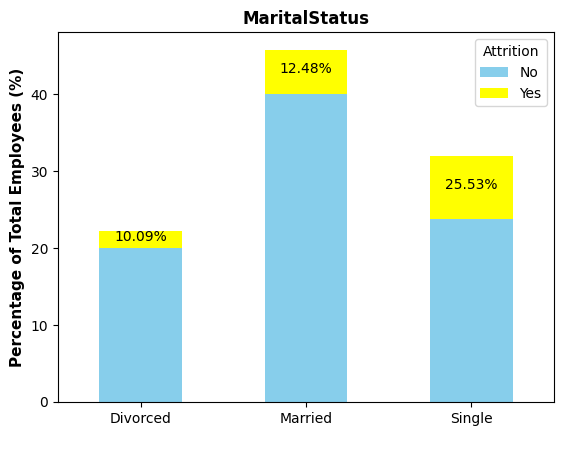

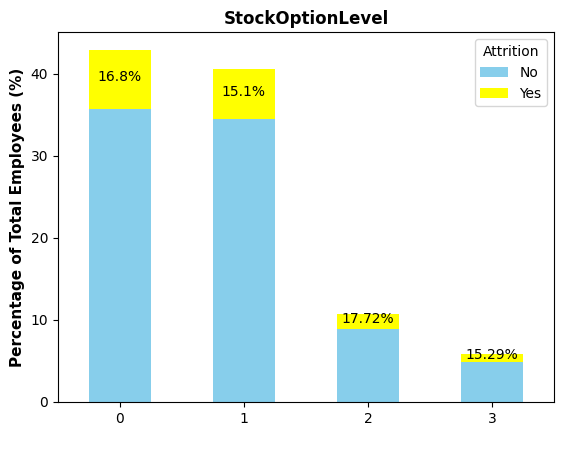

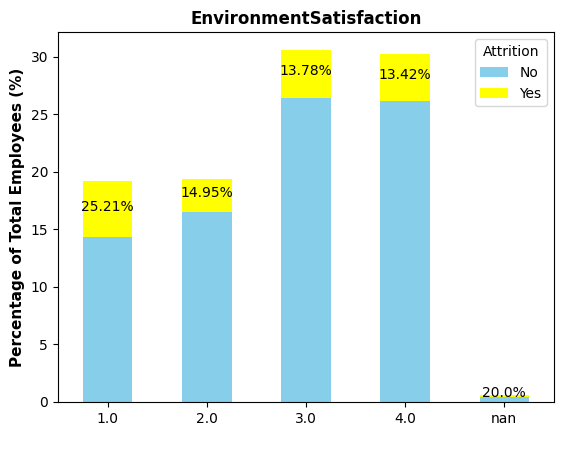

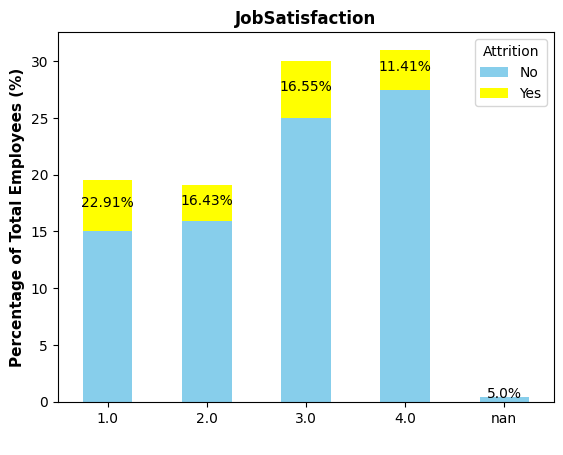

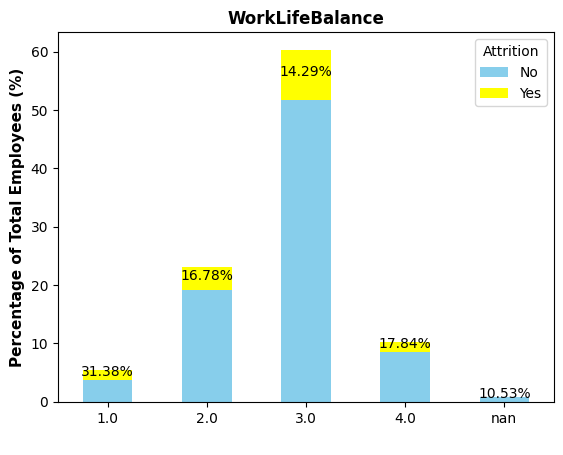

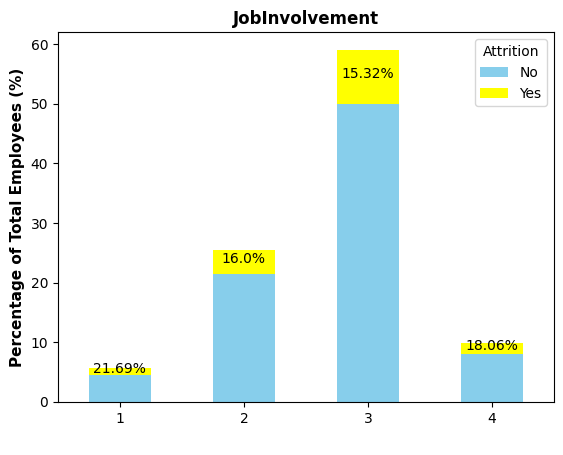

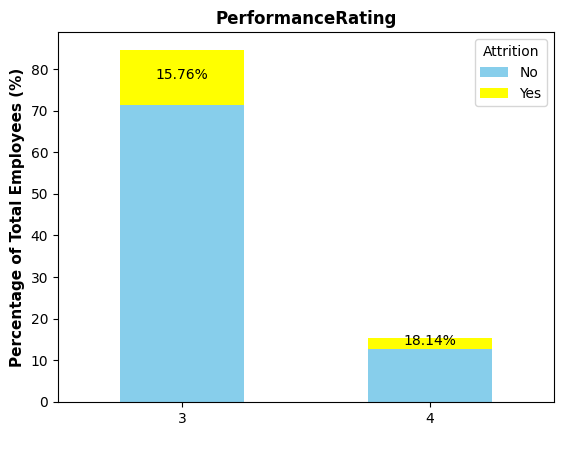

In [ ]:
for col in cats:
    if col != 'Attrition':
        dfg = df.groupby([col, 'Attrition'])['EmployeeID'].nunique().reset_index()
        dfg_a = df.groupby([col, 'Attrition'])['EmployeeID'].nunique().reset_index()
        dfg = df.groupby(col)['EmployeeID'].nunique().reset_index()

        dfg['total_df'] = [4410 for y in range(df[col].nunique())]

        dfg.rename(columns={'EmployeeID':'total_fitur'}, inplace=True)
        dfg_a.rename(columns={'EmployeeID':'subtotal'}, inplace=True)

        dfg_merge = dfg_a.merge(dfg, how='left')
        dfg_merge['ratio'] = round(dfg_merge['subtotal']/dfg_merge['total_df']*100, 2)
        dfg_merge['sub_ratio'] = round(dfg_merge['subtotal']/dfg_merge['total_fitur']*100, 2)

        dfg_merge1 = dfg_merge.pivot_table(index=col, columns='Attrition', values='sub_ratio')
        dfg_merge2 = dfg_merge.pivot_table(index=col, columns='Attrition', values='ratio')

        # Define custom colors for the colormap (red and blue)
        custom_colors = ['skyblue', 'yellow']
        custom_cmap = ListedColormap(custom_colors)

        bar = dfg_merge2.plot(kind='bar', stacked=True, colormap=custom_cmap)

        for i in bar.containers[int(len(bar.containers)/2):]:
            bar.bar_label(i, padding=2, fmt="{:0,.2f}%", label_type='center', labels=[f'{x}%' for x in dfg_merge1['Yes'].values], color='black')
        plt.xlabel(' ')
        plt.ylabel('Percentage of Total Employees (%)', fontsize=11, fontweight='bold')
        plt.title(col, fontsize=12, fontweight='bold')
        plt.xticks(rotation=0)
        plt.show()

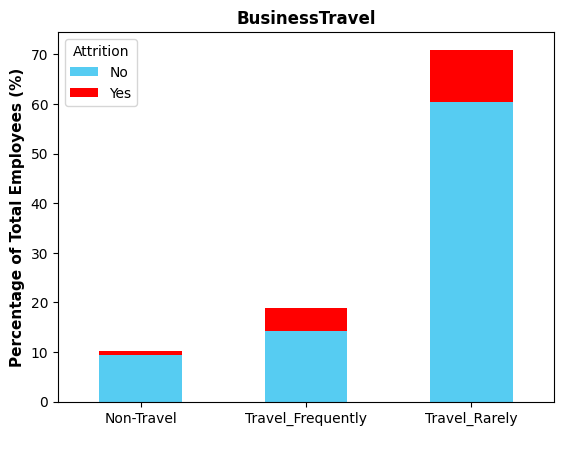

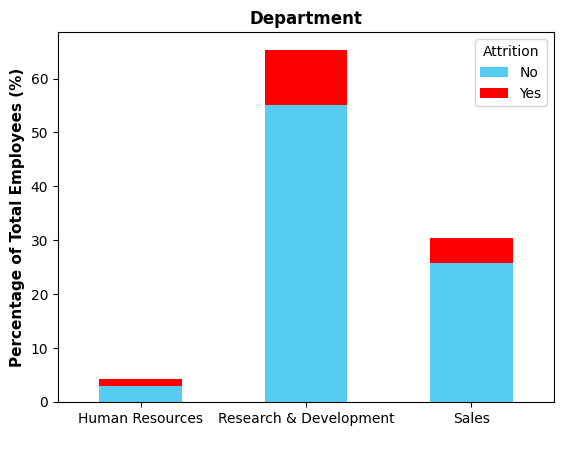

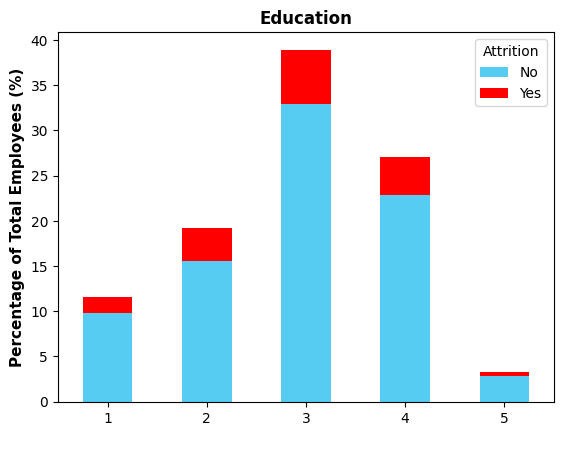

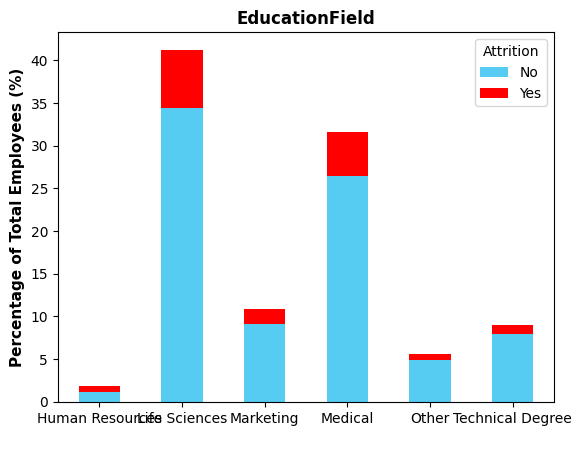

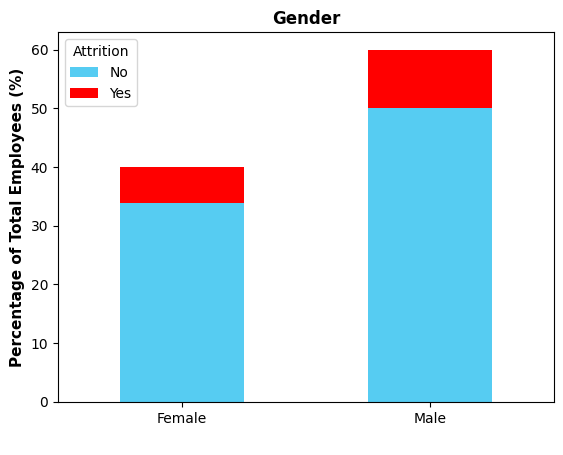

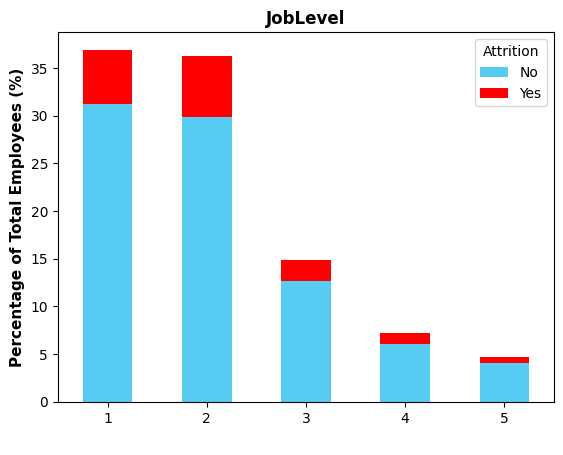

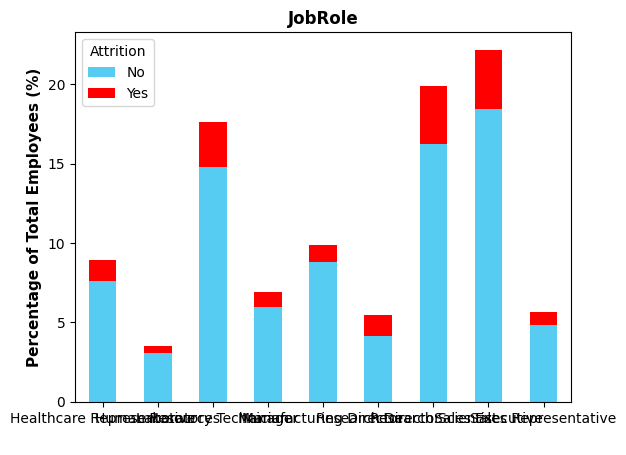

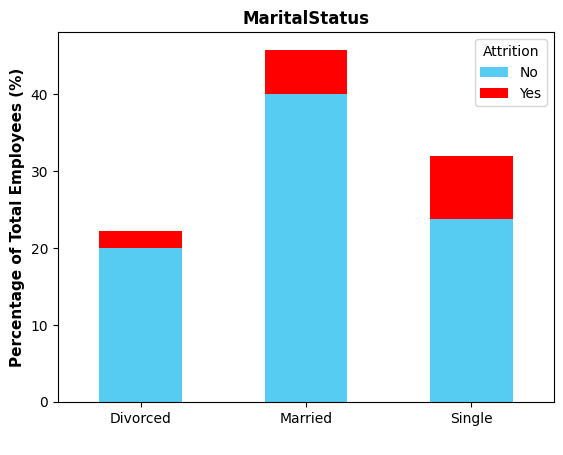

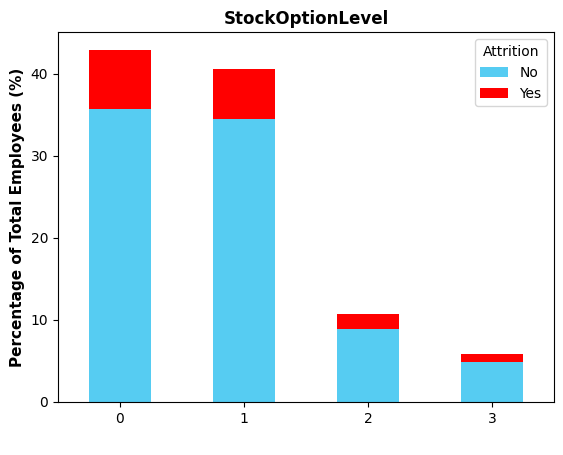

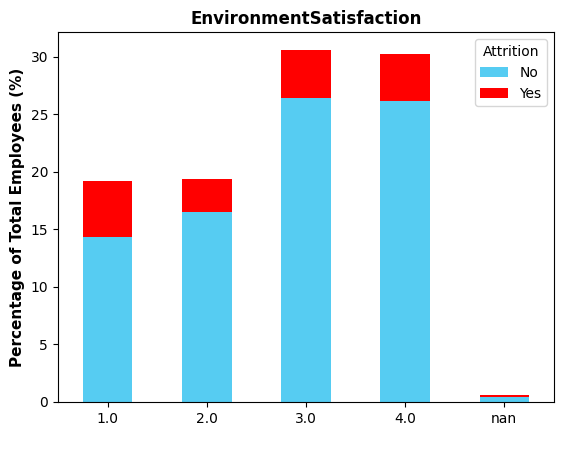

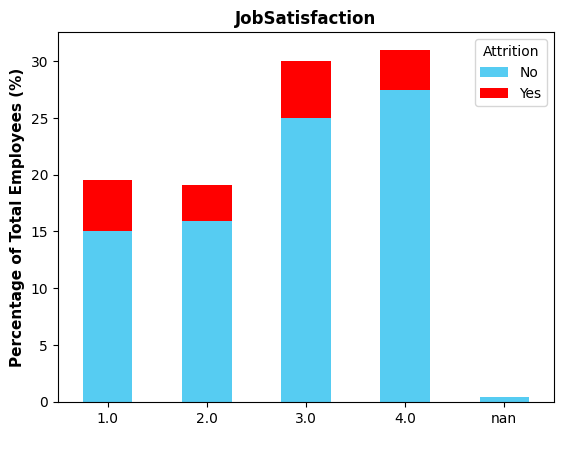

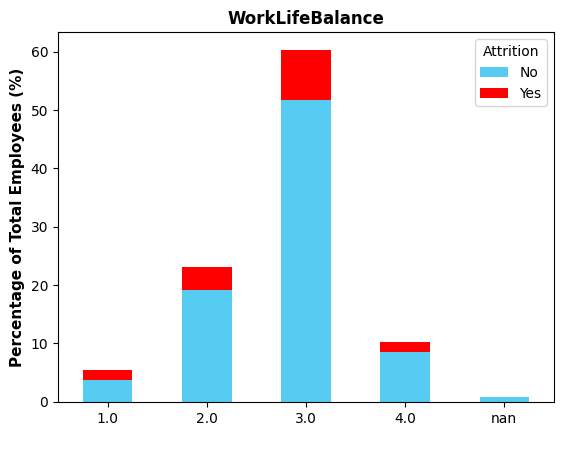

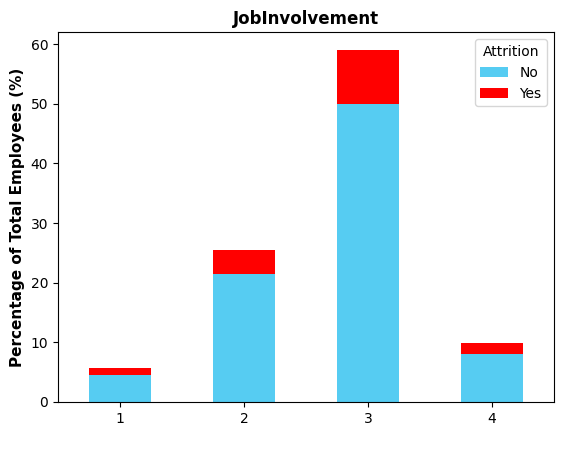

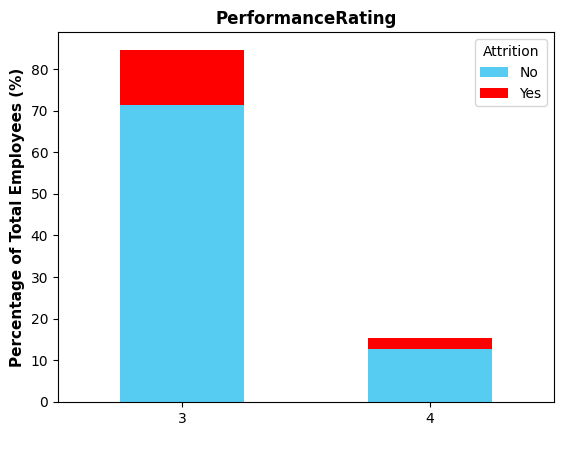

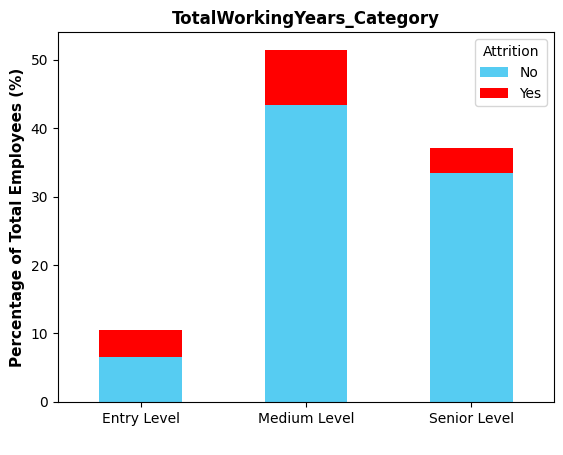

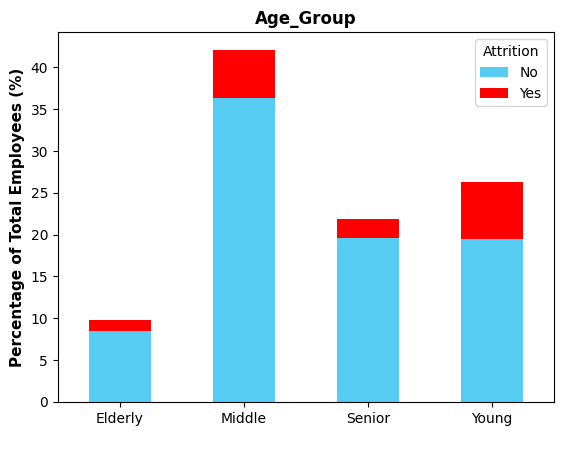

In [ ]:
for col in cats:
    if col != 'Attrition':
        dfg = df.groupby([col, 'Attrition'])['EmployeeID'].nunique().reset_index()
        dfg_a = df.groupby([col, 'Attrition'])['EmployeeID'].nunique().reset_index()
        dfg = df.groupby(col)['EmployeeID'].nunique().reset_index()

        dfg['total_df'] = [4410 for y in range(df[col].nunique())]

        dfg.rename(columns={'EmployeeID':'total_fitur'}, inplace=True)
        dfg_a.rename(columns={'EmployeeID':'subtotal'}, inplace=True)

        dfg_merge = dfg_a.merge(dfg, how='left')
        dfg_merge['ratio'] = round(dfg_merge['subtotal']/dfg_merge['total_df']*100, 2)
        dfg_merge['sub_ratio'] = round(dfg_merge['subtotal']/dfg_merge['total_fitur']*100, 2)

        dfg_merge1 = dfg_merge.pivot_table(index=col, columns='Attrition', values='sub_ratio')
        dfg_merge2 = dfg_merge.pivot_table(index=col, columns='Attrition', values='ratio')

        # Define custom colors for the colormap (red and blue)
        custom_colors = ['#56CCF2', 'red']
        custom_cmap = ListedColormap(custom_colors)

        bar = dfg_merge2.plot(kind='bar', stacked=True, colormap=custom_cmap)

        #for i in bar.containers[int(len(bar.containers)/2):]:
       #     bar.bar_label(i, padding=2, fmt="{:0,.2f}%", label_type='center', labels=[f'{x}%' for x in dfg_merge1['Yes'].values], color='black')
        plt.xlabel(' ')
        plt.ylabel('Percentage of Total Employees (%)', fontsize=11, fontweight='bold')
        plt.title(col, fontsize=12, fontweight='bold')
        plt.xticks(rotation=0)
        plt.show()

In [ ]:
#Distribution of 'Balance_category'
print(df['MaritalStatus'].describe())
print("\n---------------------\n")
print(df['MaritalStatus'].value_counts().sort_index())
print("\n---------------------\n")
print(round(df.groupby('MaritalStatus')['Attrition'].value_counts(normalize=True).mul(100),2))

count        4410
unique          3
top       Married
freq         2019
Name: MaritalStatus, dtype: object

---------------------

Divorced     981
Married     2019
Single      1410
Name: MaritalStatus, dtype: int64

---------------------

MaritalStatus  Attrition
Divorced       No           89.91
               Yes          10.09
Married        No           87.52
               Yes          12.48
Single         No           74.47
               Yes          25.53
Name: Attrition, dtype: float64


In [ ]:
#Distribution of 'Balance_category'
print(df['TotalWorkingYears_Category'].describe())
print("\n---------------------\n")
print(df['TotalWorkingYears_Category'].value_counts().sort_index())
print("\n---------------------\n")
print(round(df.groupby('TotalWorkingYears_Category')['Attrition'].value_counts(normalize=True).mul(100),2))

count             4368
unique               3
top       Medium Level
freq              2270
Name: TotalWorkingYears_Category, dtype: object

---------------------

Entry Level      461
Medium Level    2270
Senior Level    1637
Name: TotalWorkingYears_Category, dtype: int64

---------------------

TotalWorkingYears_Category  Attrition
Entry Level                 No           62.47
                            Yes          37.53
Medium Level                No           84.32
                            Yes          15.68
Senior Level                No           89.92
                            Yes          10.08
Name: Attrition, dtype: float64


In [ ]:
#Distribution of 'Balance_category'
print(df['Age_Group'].describe())
print("\n---------------------\n")
print(df['Age_Group'].value_counts().sort_index())
print("\n---------------------\n")
print(round(df.groupby('Age_Group')['Attrition'].value_counts(normalize=True).mul(100),2))

count       4410
unique         4
top       Middle
freq        1857
Name: Age_Group, dtype: object

---------------------

Elderly     429
Middle     1857
Senior      966
Young      1158
Name: Age_Group, dtype: int64

---------------------

Age_Group  Attrition
Elderly    No           87.41
           Yes          12.59
Middle     No           86.27
           Yes          13.73
Senior     No           89.44
           Yes          10.56
Young      No           74.09
           Yes          25.91
Name: Attrition, dtype: float64


#### **Numeric**

In [ ]:
df[nums].describe()

Age  DistanceFromHome  MonthlyIncome  NumCompaniesWorked  \
count  4410.000000       4410.000000    4410.000000         4391.000000   
mean     36.923810          9.192517   65029.312925            2.694830   
std       9.133301          8.105026   47068.888559            2.498887   
min      18.000000          1.000000   10090.000000            0.000000   
25%      30.000000          2.000000   29110.000000            1.000000   
50%      36.000000          7.000000   49190.000000            2.000000   
75%      43.000000         14.000000   83800.000000            4.000000   
max      60.000000         29.000000  199990.000000            9.000000   

       PercentSalaryHike  TotalWorkingYears  TrainingTimesLastYear  \
count        4410.000000        4401.000000            4410.000000   
mean           15.209524          11.279936               2.799320   
std             3.659108           7.782222               1.288978   
min            11.000000           0.000000               0.000000   
25%            12.000000           6.000000               2.000000   
50%            14.000000          10.000000               3.000000   
75%            18.000000          15.000000               3.000000   
max            25.000000          40.000000               6.000000   

       YearsAtCompany  YearsSinceLastPromotion  YearsWithCurrManager  
count     4410.000000              4410.000000           4410.000000  
mean         7.008163                 2.187755              4.123129  
std          6.125135                 3.221699              3.567327  
min          0.000000                 0.000000              0.000000  
25%          3.000000                 0.000000              2.000000  
50%          5.000000                 1.000000              3.000000  
75%          9.000000                 3.000000              7.000000  
max         40.000000                15.000000             17.000000

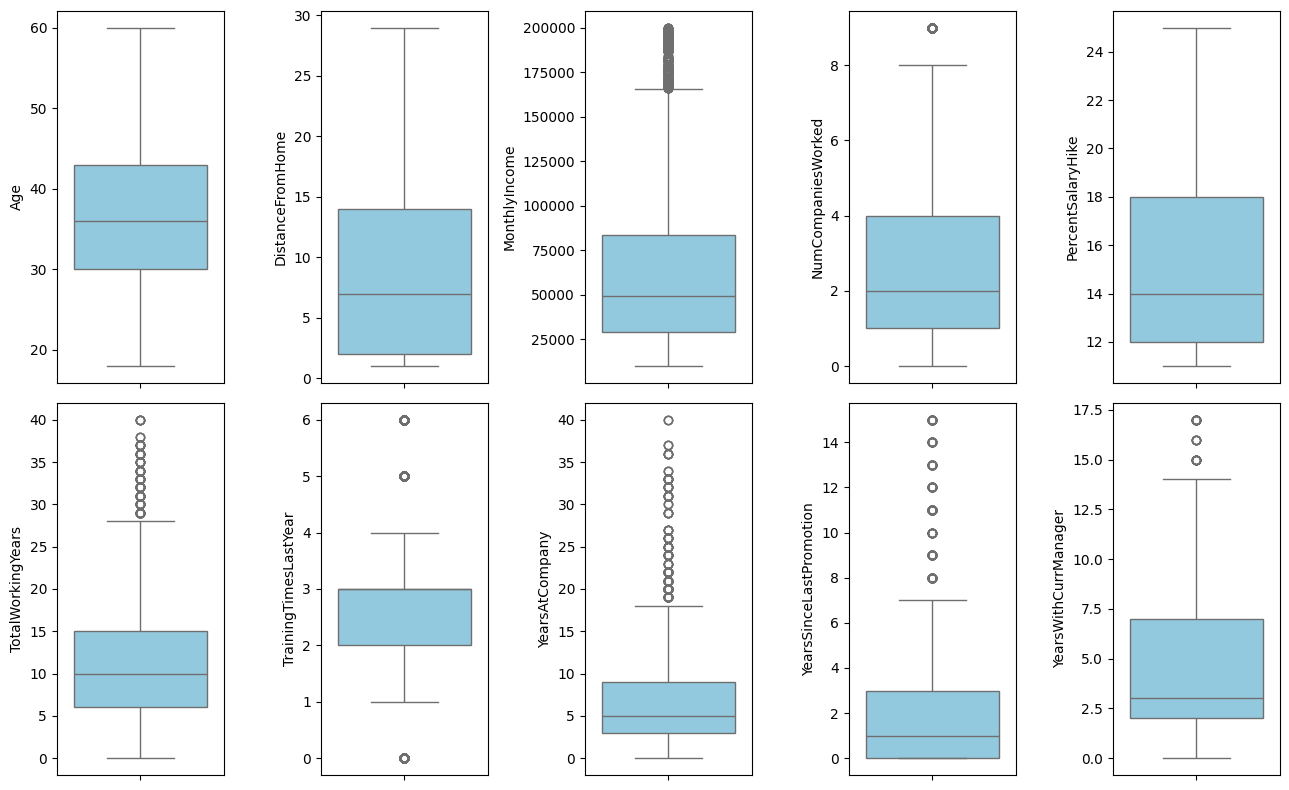

In [ ]:
# individual boxplot
plt.figure(figsize=(13, 8))
for i in range(0, len(nums)):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=df[nums[i]], color='skyblue')
    plt.tight_layout()

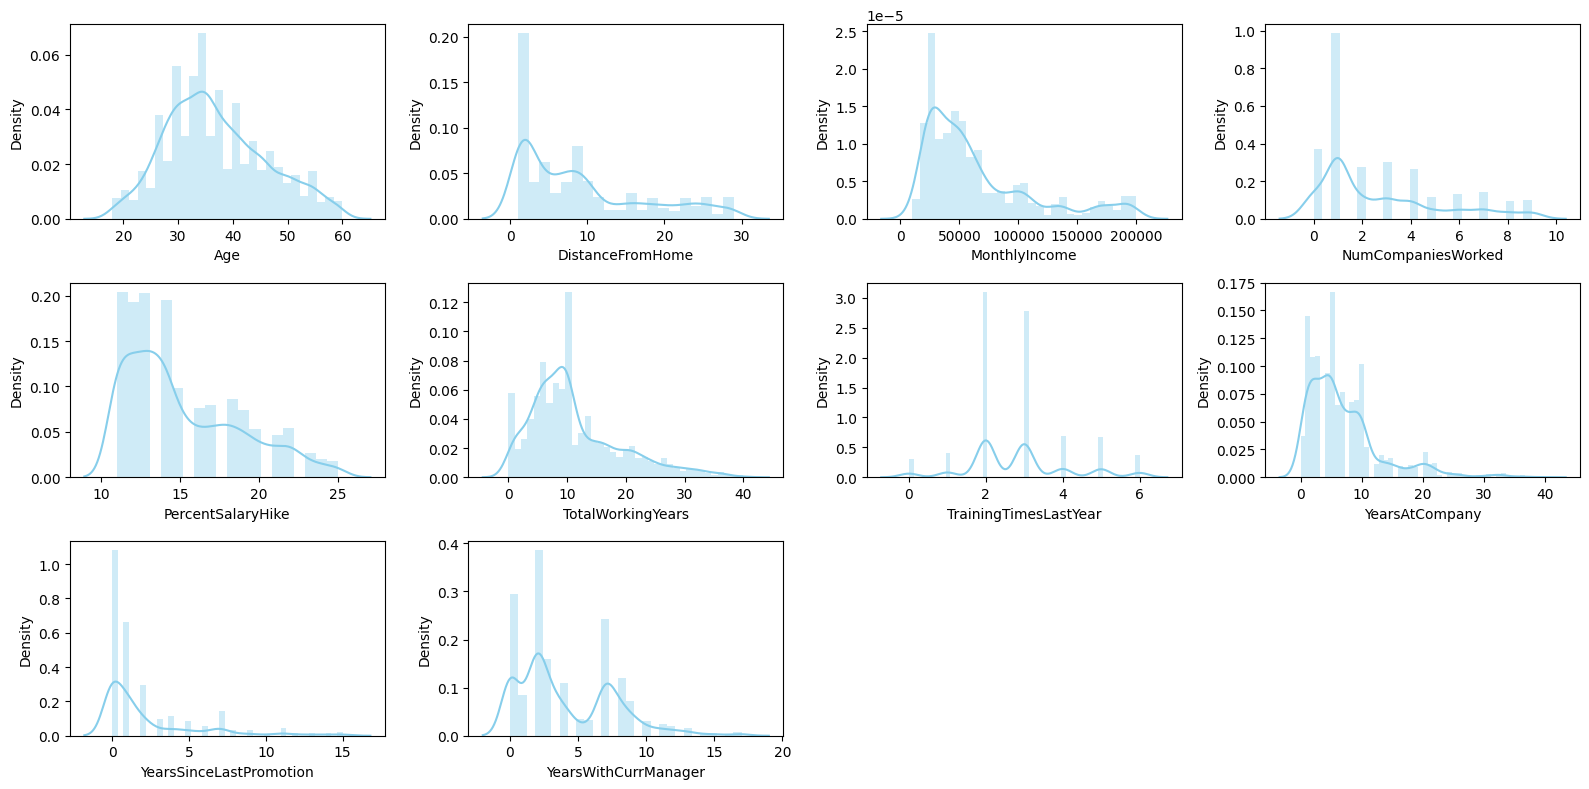

In [ ]:
# individual distplot
plt.figure(figsize=(16, 8))
for i in range(0, len(nums)):
    plt.subplot(3, 4, i+1)
    sns.distplot(x=df[nums[i]], color='skyblue')
    plt.xlabel(nums[i])
    plt.tight_layout()

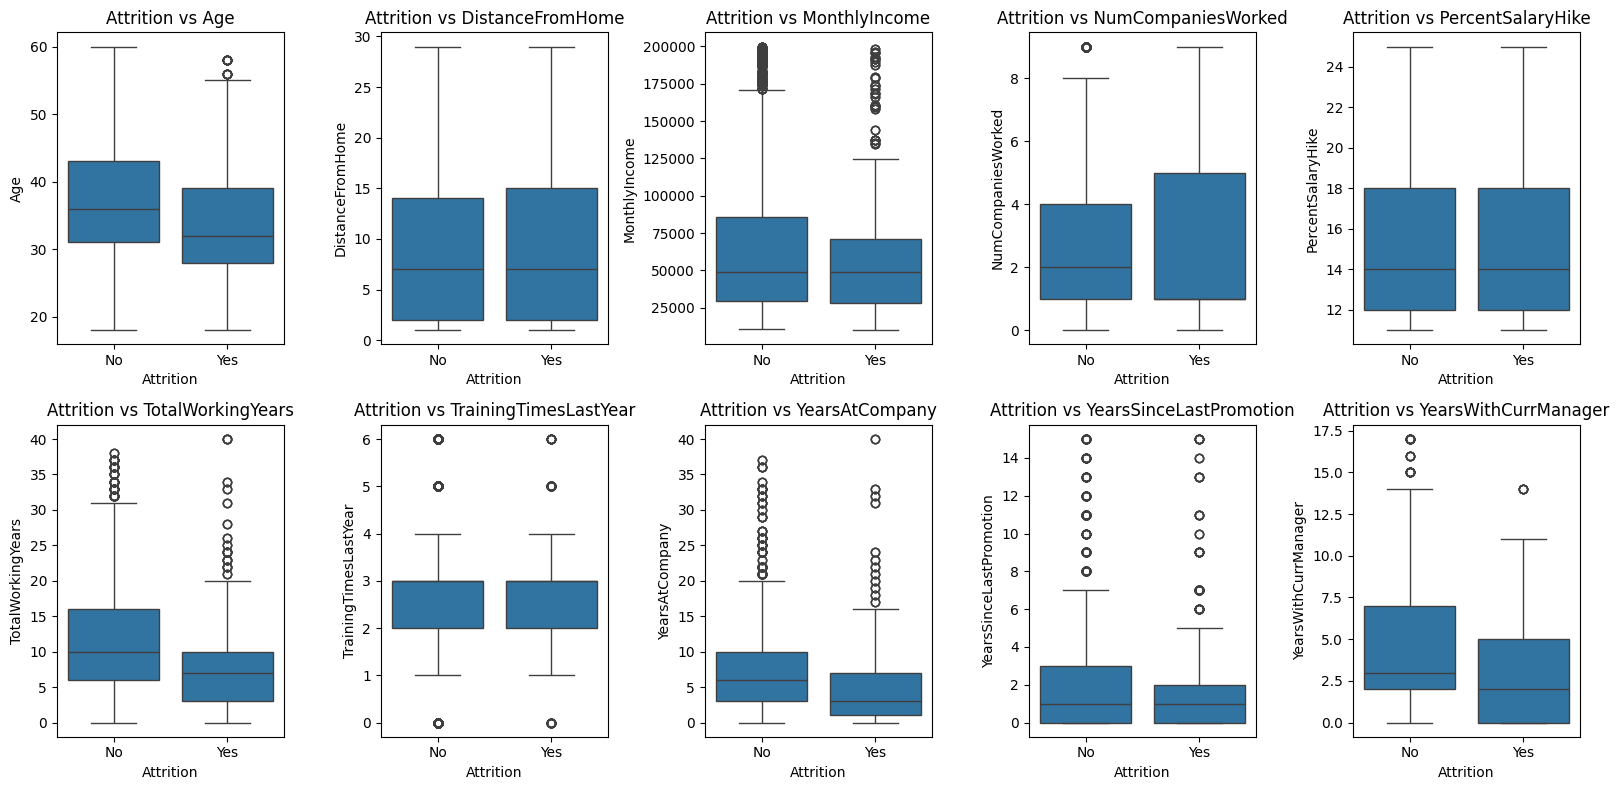

In [ ]:
plt.figure(figsize=(16, 8))
for i, feature in enumerate(nums, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(data=df, x='Attrition', y=feature)
    plt.title(f'Attrition vs {feature}')
plt.tight_layout()
plt.show()

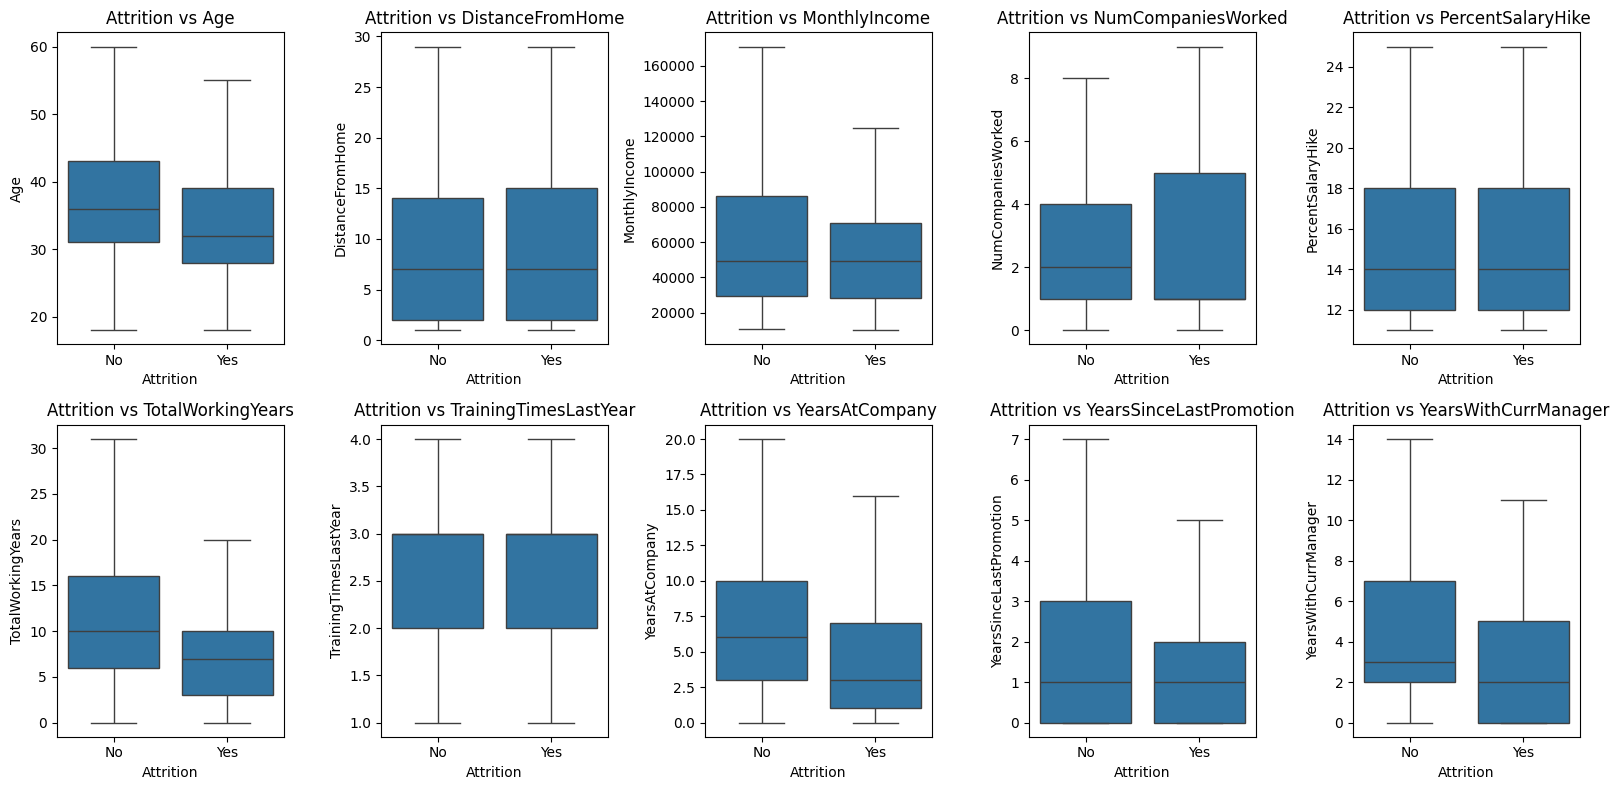

In [ ]:
# menampilkan boxplot fitur terhadap attrition tanpa outliers
plt.figure(figsize=(16, 8))
for i, feature in enumerate(nums, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(data=df, x='Attrition', y=feature, showfliers= False)
    plt.title(f'Attrition vs {feature}')
plt.tight_layout()
plt.show()

### **Multivariate Analysis**

In [ ]:
#drop kolom dari df raw
df_raw = df_raw.drop(columns=['EmployeeCount', 'EmployeeID', 'StandardHours'])

<Axes: >

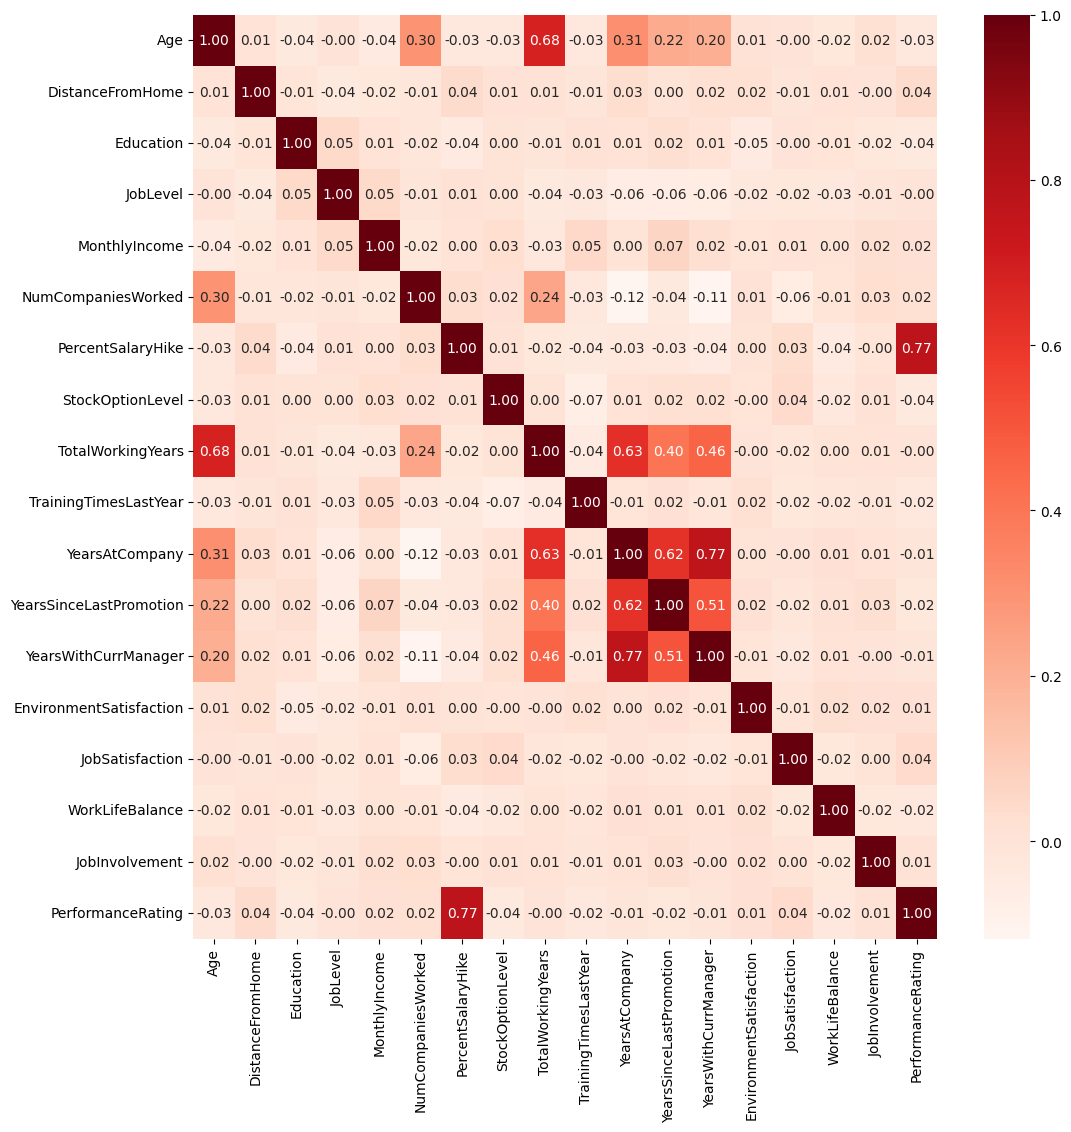

In [ ]:
plt.figure(figsize=(12, 12))

# Membuat heatmap
numeric_df = df_raw.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), cmap='Reds', annot=True, fmt='.2f')

- Kolom yang memiliki nilai korelasi cukup tinggi adalah Age, NumCompaniesWork, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager.
- Kolom yang berpotensi mengalami redudansi (>0.7) sehingga salah satunya harus didrop adalah PercentSalaryHike, YearsAtCompany, YearsWithCurrManager, PerformanceRating

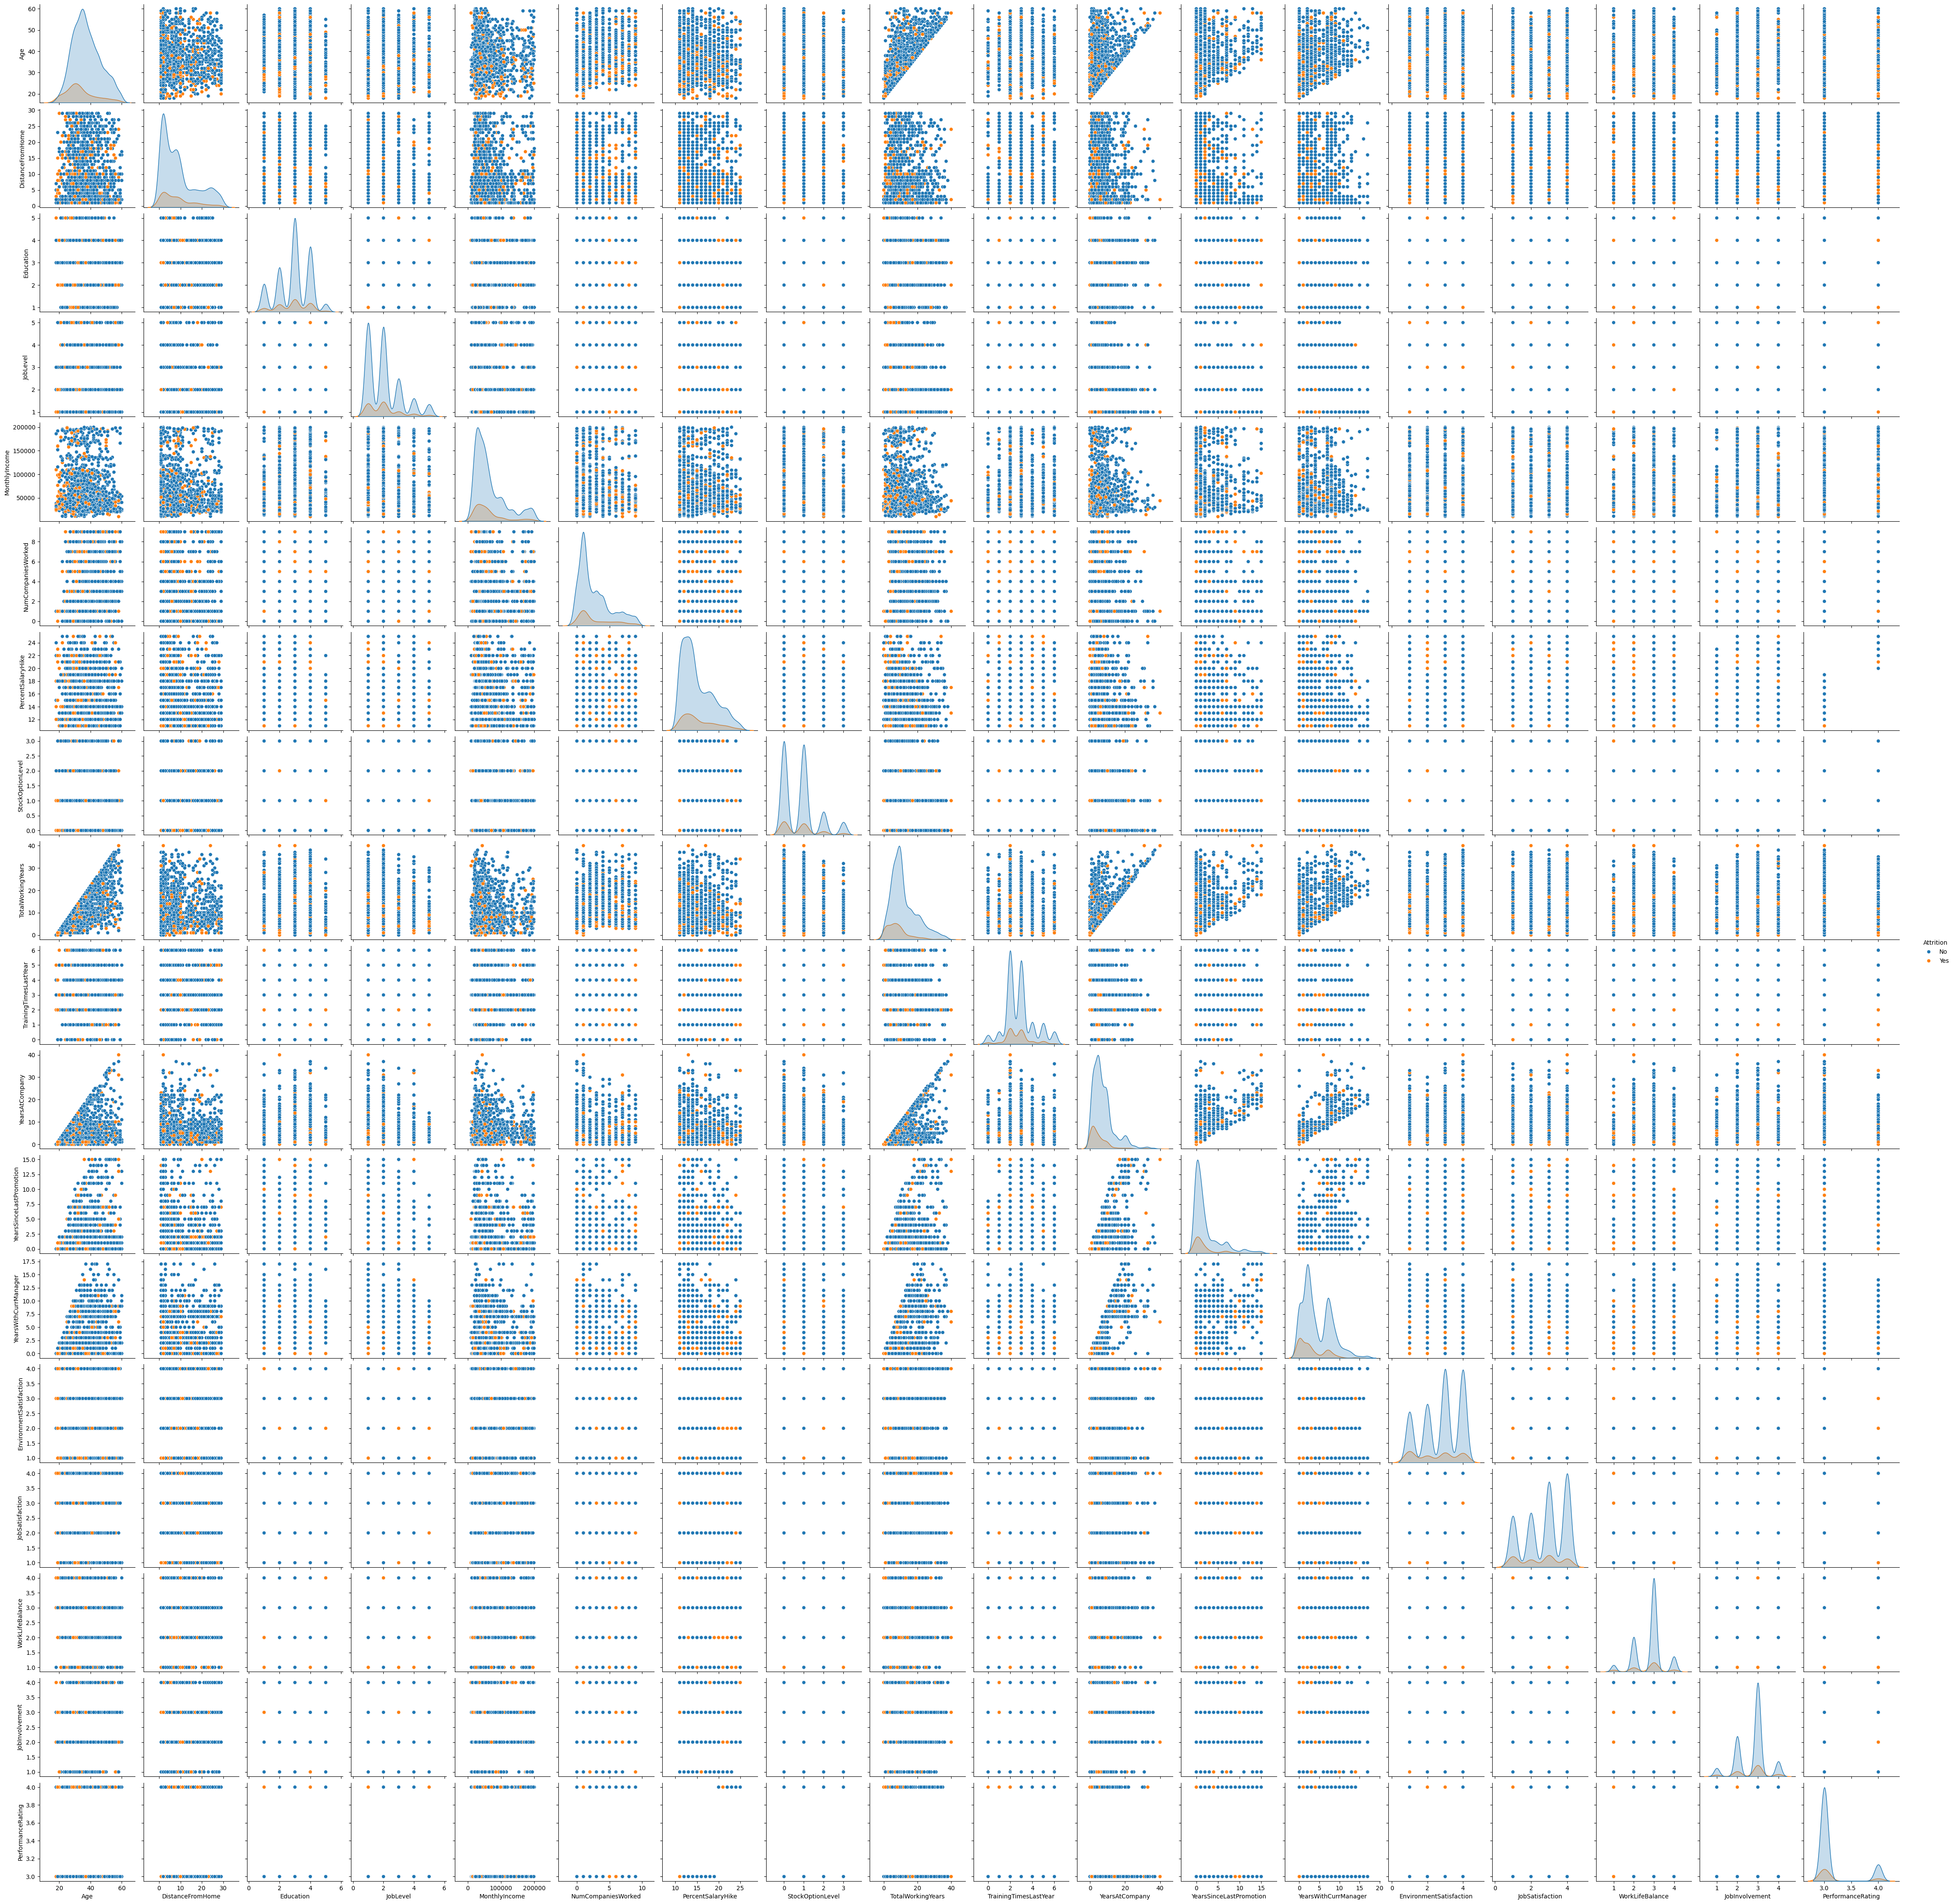

In [ ]:
sns.pairplot(df_raw, diag_kind='kde', hue='Attrition')

## **3. Data Preprocessing**

### **Handling missing value dan duplicated data**

In [ ]:
df = df_raw.copy()

In [ ]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
dtype: int64

In [ ]:
df['NumCompaniesWorked'].fillna(df['NumCompaniesWorked'].mode()[0], inplace=True)
df['EnvironmentSatisfaction'].fillna(df['EnvironmentSatisfaction'].mode()[0], inplace=True)
df['JobSatisfaction'].fillna(df['JobSatisfaction'].median(), inplace=True)
df['TotalWorkingYears'].fillna(df['TotalWorkingYears'].median(), inplace=True)
df['WorkLifeBalance'].fillna(df['WorkLifeBalance'].mode()[0], inplace=True)

In [ ]:
df.isna().sum()

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
dtype: int64

In [ ]:
print(f"Jumlah data duplikat keseluruhan = ", df.duplicated().sum())
print(f"Jumlah data duplikat subset 'EmployeeID' = ", df.duplicated(subset=['EmployeeID']).sum())

Jumlah data duplikat keseluruhan =  0
Jumlah data duplikat subset 'EmployeeID' =  0


In [ ]:
df = df.drop(columns=['EmployeeCount', 'EmployeeID', 'Over18', 'StandardHours'])

Tidak terdapat data duplikat sehingga kolom `EmployeeCount` dan `EmployeeID` dapat didrop. Kolom `Over18`, dan `StandardHours` didrop karena tidak memiliki korelasi untuk analisis.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4391 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

### **Encoding**

In [ ]:
df['Attrition'] = df['Attrition'].replace({'No':0,'Yes':1})
df.head(2)

Age  Attrition     BusinessTravel              Department  \
0   51          0      Travel_Rarely                   Sales   
1   31          1  Travel_Frequently  Research & Development   

   DistanceFromHome  Education EducationField  Gender  JobLevel  \
0                 6          2  Life Sciences  Female         1   
1                10          1  Life Sciences  Female         1   

                     JobRole  ... TotalWorkingYears  TrainingTimesLastYear  \
0  Healthcare Representative  ...               1.0                      6   
1         Research Scientist  ...               6.0                      3   

   YearsAtCompany  YearsSinceLastPromotion  YearsWithCurrManager  \
0               1                        0                     0   
1               5                        1                     4   

   EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  JobInvolvement  \
0                      3.0              4.0              2.0               3   
1                      3.0              2.0              4.0               2   

   PerformanceRating  
0                  3  
1                  4  

[2 rows x 25 columns]

In [ ]:
# one-hot encoding pada kolom Gender
cat2 = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender']
for cat in cat2[:]:
    nominal_encoded = pd.get_dummies(df[cat], prefix=cat)
    df = pd.concat([df, nominal_encoded], axis=1)

# mengonversi nilai boolean menjadi bilangan bulat
for column in df.columns:
    if df[column].dtype == bool:
        df[column] = df[column].astype(int)

# menghapus kolom-kolom yang bertipe objek (kecuali kolom 'Attrition')
for column in df.columns:
    if df[column].dtype == object and column != 'Attrition':
        df.drop(column, axis=1, inplace=True)

df.head(2)

Age  Attrition  DistanceFromHome  Education  JobLevel  MonthlyIncome  \
0   51          0                 6          2         1         131160   
1   31          1                10          1         1          41890   

   NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  TotalWorkingYears  \
0                 1.0                 11                 0                1.0   
1                 0.0                 23                 1                6.0   

   ...  JobRole_Manufacturing Director  JobRole_Research Director  \
0  ...                               0                          0   
1  ...                               0                          0   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                           0                        0   
1                           1                        0   

   JobRole_Sales Representative  MaritalStatus_Divorced  \
0                             0                       0   
1                             0                       0   

   MaritalStatus_Married  MaritalStatus_Single  Gender_Female  Gender_Male  
0                      1                     0              1            0  
1                      0                     1              1            0  

[2 rows x 45 columns]

### **Train Test Split**

In [ ]:
df_sp = df.copy()

In [ ]:
X = df_sp.drop(['Attrition'],axis=1,inplace=False)
y = df_sp['Attrition']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state=20, stratify = y)

### **Handling Outliers dan Feature Transformation**

In [ ]:
nums_clean = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
              'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
              'YearsWithCurrManager']

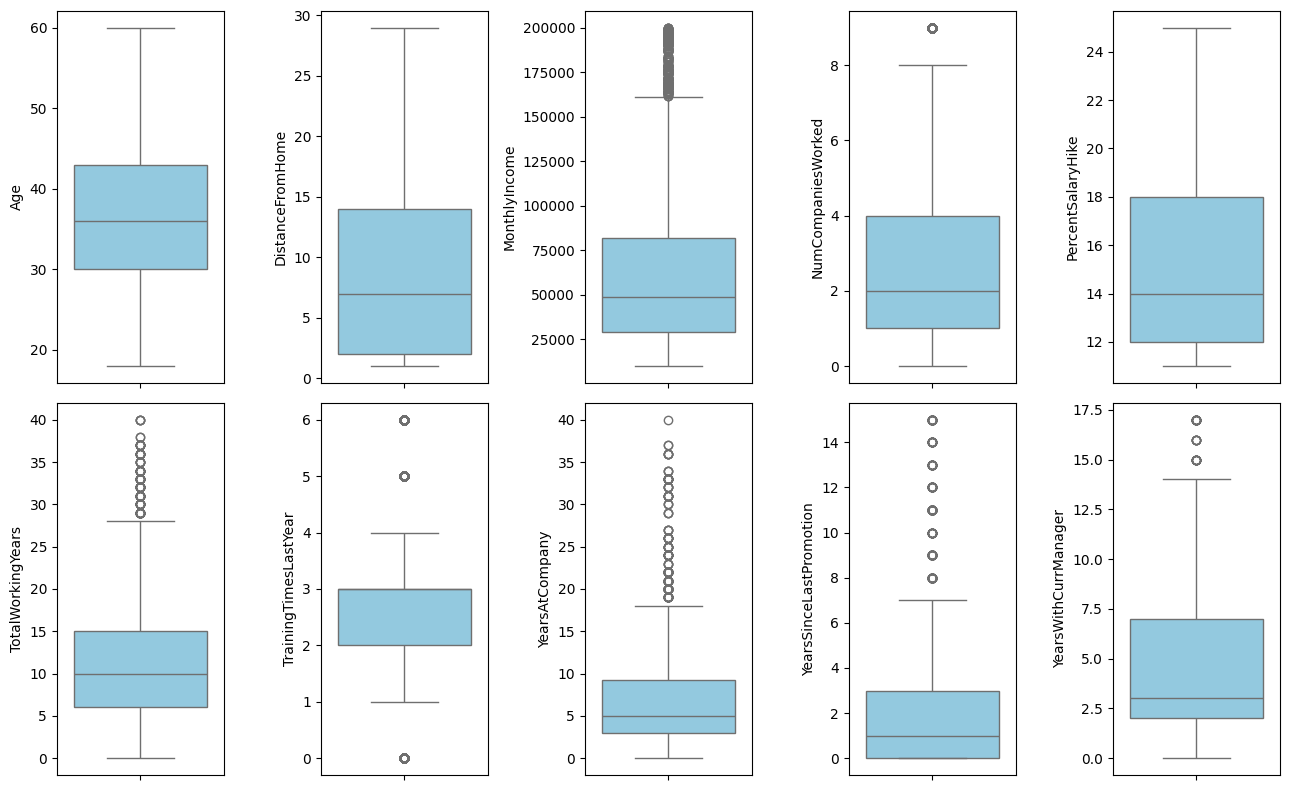

In [ ]:
plt.figure(figsize=(13, 8))
for i in range(0, len(nums_clean)):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=Xtrain[nums_clean[i]], color='skyblue')
    plt.tight_layout()

In [ ]:
for var in nums_clean:
  Xtrain[var]= (Xtrain[var]).apply(np.log1p)
  Xtest[var]= (Xtest[var]).apply(np.log1p)

In [ ]:
ss = StandardScaler()

for col in nums_clean:

    scaler = ss.fit(Xtrain[[col]])

    Xtrain[[col]] = ss.transform(Xtrain[[col]])
    Xtest[[col]] = ss.transform(Xtest[[col]])

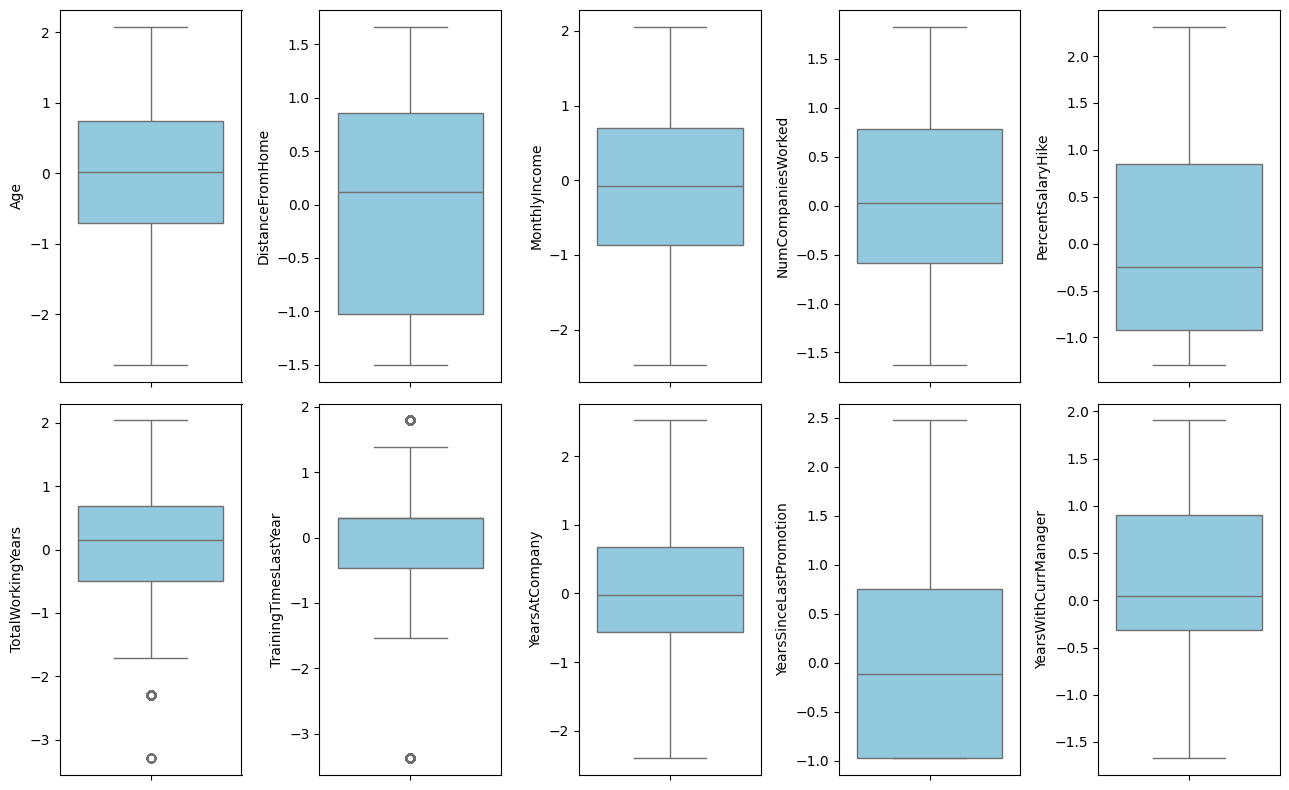

In [ ]:
plt.figure(figsize=(13, 8))
for i in range(0, len(nums_clean)):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=Xtrain[nums_clean[i]], color='skyblue')
    plt.tight_layout()

In [ ]:
Xtrain.head(5)

Age  DistanceFromHome  Education  JobLevel  MonthlyIncome  \
1672 -1.280240          0.485046          4         3      -0.987362   
3480 -0.297736          0.379416          2         4      -0.866372   
3909 -0.551186          0.862317          2         1       1.737926   
2090  0.652997         -0.062396          4         5       1.761651   
1079 -0.970150          1.420632          2         2       0.456212   

      NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  \
1672            1.006674           0.623703                 3   
3480            0.812180          -0.560445                 0   
3909           -0.433465          -1.327949                 2   
2090            1.289113          -1.327949                 0   
1079           -0.433465           0.868441                 1   

      TotalWorkingYears  TrainingTimesLastYear  ...  \
1672          -0.012358               0.335296  ...   
3480          -0.560280              -0.309674  ...   
3909          -0.343126               1.123176  ...   
2090           0.233593               0.335296  ...   
1079          -2.580812              -0.309674  ...   

      JobRole_Manufacturing Director  JobRole_Research Director  \
1672                               0                          0   
3480                               1                          0   
3909                               0                          0   
2090                               0                          0   
1079                               0                          0   

      JobRole_Research Scientist  JobRole_Sales Executive  \
1672                           0                        0   
3480                           0                        0   
3909                           0                        1   
2090                           0                        1   
1079                           0                        0   

      JobRole_Sales Representative  MaritalStatus_Divorced  \
1672                             0                       1   
3480                             0                       0   
3909                             0                       0   
2090                             0                       0   
1079                             0                       0   

      MaritalStatus_Married  MaritalStatus_Single  Gender_Female  Gender_Male  
1672                      0                     0              0            1  
3480                      0                     1              0            1  
3909                      1                     0              0            1  
2090                      1                     0              0            1  
1079                      1                     0              0            1  

[5 rows x 44 columns]

### **Imbalance Data**

In [ ]:
ytrain.value_counts()

0    2959
1     569
Name: Attrition, dtype: int64

In [ ]:
smote = SMOTE(sampling_strategy=1, random_state=20)
Xtrain_over, ytrain_over = smote.fit_resample(Xtrain, ytrain)

print('SMOTE')
print(pd.Series(ytrain_over).value_counts())

SMOTE
0    2959
1    2959
Name: Attrition, dtype: int64


### **Feature Selection**

**Mutual Information Classification**

In [ ]:
X = df.drop(columns=['Attrition'])
y= df['Attrition']

mi_scores = mutual_info_classif(X, y,random_state=20)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)

**Chi_square Test**

In [ ]:
X = df.drop(columns=['Attrition'])
y= df['Attrition']

chi2_stats, p_values = chi2(X, y)
chi2_stats = pd.Series(chi2_stats, name="Chi2 Scores", index=X.columns)
chi2_stats = chi2_stats.sort_values(ascending=False)
print(chi2_stats)

In [ ]:
p_values = pd.Series(p_values, name="p_value", index=X.columns)
p_values = p_values.sort_values(ascending=True)
print(p_values)

**ANOVA**

In [ ]:
X = df.drop(columns=['Attrition'])
y= df['Attrition']

f_statistic, p_values = f_classif(X, y)
f_statistic = pd.Series(f_statistic, name="f Scores", index=X.columns)
f_statistic = f_statistic.sort_values(ascending=False)
print(f_statistic)

In [ ]:
p_values = pd.Series(p_values, name="p_value", index=X.columns)
p_values = p_values.sort_values(ascending=True)
print(p_values)

**Drop kolom BusinessTravel dan EducationField**

In [ ]:
df = df.drop(columns=['EducationField_Medical'])

In [ ]:
df.info()

## **4. Modelling**

##### **Helper Function**

In [ ]:
def eval_classification(model, smote=True):
    y_pred = model.predict(Xtest)
    y_pred_train = model.predict(Xtrain)
    y_pred_proba = model.predict_proba(Xtest)
    y_pred_proba_train = model.predict_proba(Xtrain)

    model1 = Pipeline([
        ('sampling', SMOTE(sampling_strategy=1, random_state=20)),
        ('classification', model)
    ])

    print("Accuracy (Train): %.2f" % accuracy_score(ytrain, y_pred_train))
    print("Accuracy (Test): %.2f" % accuracy_score(ytest, y_pred))

    print("Precision (Train): %.2f" % precision_score(ytrain, y_pred_train))
    print("Precision (Test): %.2f" % precision_score(ytest, y_pred))

    print("Recall (Train): %.2f" % recall_score(ytrain, y_pred_train))
    print("Recall (Test): %.2f" % recall_score(ytest, y_pred))

    print("F1-Score (Test): %.2f" % f1_score(ytest, y_pred))

    print("roc_auc (train-proba): %.2f" % roc_auc_score(ytrain, y_pred_proba_train[:, 1]))
    print("roc_auc (test-proba): %.2f" % roc_auc_score(ytest, y_pred_proba[:, 1]))

    if smote==True:
      cv = RepeatedStratifiedKFold(random_state=20, n_repeats = 3)
      score = cross_validate(model1, X=Xtrain, y=ytrain, cv=cv, scoring='roc_auc', return_train_score=True)
      print("roc_auc (crossval train): " + str(score['train_score'].mean()))
      print("roc_auc (crossval test): " + str(score['test_score'].mean()))


def grid_pipe(pipedict, hyperdict, scoring='recall', display=True):
    fitted_models={}
    for name, pipeline in pipedict.items():
        # membangun grid search
        model = GridSearchCV(estimator= pipeline,
                             param_grid= hyperdict[name],
                             scoring= scoring,
                             cv= 5, verbose= 2, n_jobs= -1,
                             return_train_score = True)

        # fit menggunakan grid search
        start = time.time()
        model.fit(Xtrain, ytrain)
        end = time.time()

        # menambahkan model
        fitted_models[name]=model
        if display:
            print(f'The {name} model has been fitted.') # print ketika model telah fit
            print('Total Fit Time: %.3fs' % (end-start)) # print fit time
            print('Best params:\n', model.best_params_,'\n') # print parameter terbaik

    return fitted_models

def confusion(model):
    y_pred_proba = model.predict_proba(Xtest)
    y_predict = model.predict(Xtest)
    print('Accuracy: %.2f%%' % (accuracy_score(ytest, y_predict) * 100 ))
    print('Precision: %.2f%%' % (precision_score(ytest, y_predict) * 100))
    print('Recall: %.2f%%' % (recall_score(ytest, y_predict) * 100))
    print('F1_Score: %.2f%%' % (f1_score(ytest, y_predict) * 100))
    print('ROC_AUC: %.2f%%' % (roc_auc_score(ytest, y_pred_proba[:,1]) * 100))
    confusion_matrix_model = confusion_matrix(ytest, y_predict)

    plt.figure(figsize=(12,8))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix - {model}')
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

##### **Fit Model**

**Logistic Regression**

In [ ]:
logreg = LogisticRegression()
logreg.fit(Xtrain_over, ytrain_over)

eval_classification(logreg)

Accuracy (Train): 0.83
Accuracy (Test): 0.81
Precision (Train): 0.47
Precision (Test): 0.42
Recall (Train): 0.49
Recall (Test): 0.46
F1-Score (Test): 0.44
roc_auc (train-proba): 0.80
roc_auc (test-proba): 0.72
roc_auc (crossval train): 0.8057486371885428
roc_auc (crossval test): 0.7766087227840761


**Decision Tree**

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(Xtrain_over, ytrain_over)

eval_classification(dt)

Accuracy (Train): 1.00
Accuracy (Test): 0.99
Precision (Train): 1.00
Precision (Test): 0.96
Recall (Train): 1.00
Recall (Test): 0.95
F1-Score (Test): 0.95
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.97
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.9471806393788784


**AdaBoost**

In [ ]:
ada = AdaBoostClassifier()
ada.fit(Xtrain_over, ytrain_over)

eval_classification(ada)

Accuracy (Train): 0.80
Accuracy (Test): 0.76
Precision (Train): 0.42
Precision (Test): 0.33
Recall (Train): 0.61
Recall (Test): 0.52
F1-Score (Test): 0.41
roc_auc (train-proba): 0.82
roc_auc (test-proba): 0.72
roc_auc (crossval train): 0.8271147769323757
roc_auc (crossval test): 0.7750864850632943


**Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state = 20)
rf.fit(Xtrain_over, ytrain_over)

eval_classification(rf)

Accuracy (Train): 1.00
Accuracy (Test): 0.99
Precision (Train): 1.00
Precision (Test): 0.98
Recall (Train): 1.00
Recall (Test): 0.94
F1-Score (Test): 0.96
roc_auc (train-proba): 1.00
roc_auc (test-proba): 1.00
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.9923647919213833


**XGBoost**

In [ ]:
xg = XGBClassifier()
xg.fit(Xtrain_over, ytrain_over)

eval_classification(xg)

Accuracy (Train): 1.00
Accuracy (Test): 0.99
Precision (Train): 1.00
Precision (Test): 0.96
Recall (Train): 1.00
Recall (Test): 0.97
F1-Score (Test): 0.97
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.98
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.9753963687916506


##### **Hyperparameter Tuning**

In [ ]:
# membuat alur untuk setiap classifiers
pipelines = {'logisticregression': Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=20)),
                                             ('clf', LogisticRegression())]),
             'decisiontree'      : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=20)),
                                             ('clf', DecisionTreeClassifier())]),
             'adaboost'          : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=20)),
                                             ('clf', AdaBoostClassifier())]),
             'randomforest'      : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=20)),
                                             ('clf', RandomForestClassifier(random_state = 20))]),
             'xgboost'           : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=20)),
                                             ('clf', XGBClassifier(nthread=6, tree_method='hist',  predictor='cpu_predictor'))])}

# menentukan Hyperparameters untuk setiap pipeline
hyperparameters_lr = {'clf__C': [0.01, 0.02, 0.03]}

hyperparameters_dt = {'clf__max_depth'        : [14, 15, 16], # kedalaman maksimum pohon
                      'clf__min_samples_split': [1, 2, 5], # jumlah sampel minimum yang diperlukan untuk memisahkan sebuah node
                      'clf__min_samples_leaf' : [0.5, 1, 2], # jumlah minimum sampel yang diperlukan di setiap leaf node
                      'clf__criterion'        : ['gini','entropy']} # mengukur kualitas pemisahan

hyperparameters_ada = {'clf__learning_rate' : [0.26, 0.29, 0.32], # laju pembelajaran untuk mengontrol setiap estimator
                      'clf__n_estimators'   : [30, 35, 40], # jumlah estimator dalam ensemble
                      'clf__algorithm'      : ['SAMME', 'SAMME.R']}

hyperparameters_rf = {'clf__n_estimators'     : [80, 90, 100], # jumlah pohon dalam ensemble
                      'clf__criterion'        : ['entropy', 'gini'], # kriteria untuk membuat pohon
                      'clf__max_features'     : ['sqrt'], # fitur untuk mencari pemisahan terbaik
                      'clf__min_samples_leaf' : [0.1, 0.2, 0.3]} # jumlah minimum sampel

hyperparameters_xgb = {'clf__eta'             : [0.35],
                       'clf__max_depth'       : [3, 4, 5], # kedalaman maksimum setiap pohon dalam ensemble
                       'clf__scale_pos_weight': [1, 3, 5]}

# inisiasi hyperparameter
hyperparameters = {'logisticregression':hyperparameters_lr,
                   'decisiontree': hyperparameters_dt,
                   'adaboost': hyperparameters_ada,
                   'randomforest':hyperparameters_rf,
                   'xgboost': hyperparameters_xgb}

In [ ]:
fitted_models = grid_pipe(pipelines, hyperparameters, scoring='recall')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
The logisticregression model has been fitted.
Total Fit Time: 3.866s
Best params:
 {'clf__C': 0.01} 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
The decisiontree model has been fitted.
Total Fit Time: 12.356s
Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2} 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The adaboost model has been fitted.
Total Fit Time: 24.701s
Best params:
 {'clf__algorithm': 'SAMME', 'clf__learning_rate': 0.29, 'clf__n_estimators': 30} 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The randomforest model has been fitted.
Total Fit Time: 26.704s
Best params:
 {'clf__criterion': 'entropy', 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 0.2, 'clf__n_estimators': 80} 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The xgboost model has been fitted.
Total Fit Time: 15.526

##### **Result After Hyperparameter Tuning**

**Logistic Regression**

In [ ]:
logreg = LogisticRegression(C=0.01)
logreg.fit(Xtrain_over, ytrain_over)

eval_classification(logreg)

Accuracy (Train): 0.79
Accuracy (Test): 0.77
Precision (Train): 0.40
Precision (Test): 0.35
Recall (Train): 0.57
Recall (Test): 0.51
F1-Score (Test): 0.42
roc_auc (train-proba): 0.79
roc_auc (test-proba): 0.73
roc_auc (crossval train): 0.7869660680979973
roc_auc (crossval test): 0.7667725014550889


**Decision Tree**

In [ ]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_leaf= 1, min_samples_split= 2)
dt.fit(Xtrain_over, ytrain_over)

eval_classification(dt)

Accuracy (Train): 0.99
Accuracy (Test): 0.98
Precision (Train): 0.96
Precision (Test): 0.90
Recall (Train): 1.00
Recall (Test): 0.95
F1-Score (Test): 0.92
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.97
roc_auc (crossval train): 0.9991690350097684
roc_auc (crossval test): 0.9455968845388979


**Adaboost**

In [ ]:
ada = AdaBoostClassifier(algorithm = 'SAMME', learning_rate= 0.29, n_estimators= 35)
ada.fit(Xtrain_over, ytrain_over)
eval_classification(ada)

Accuracy (Train): 0.68
Accuracy (Test): 0.66
Precision (Train): 0.29
Precision (Test): 0.26
Recall (Train): 0.69
Recall (Test): 0.60
F1-Score (Test): 0.36
roc_auc (train-proba): 0.76
roc_auc (test-proba): 0.68
roc_auc (crossval train): 0.7661991360307225
roc_auc (crossval test): 0.7434856235953018


**Random Forest**

In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', min_samples_leaf=0.3, n_estimators=90, random_state=20)
rf.fit(Xtrain_over, ytrain_over)

eval_classification(rf)

Accuracy (Train): 0.62
Accuracy (Test): 0.61
Precision (Train): 0.24
Precision (Test): 0.22
Recall (Train): 0.61
Recall (Test): 0.56
F1-Score (Test): 0.31
roc_auc (train-proba): 0.68
roc_auc (test-proba): 0.63
roc_auc (crossval train): 0.6838030113036785
roc_auc (crossval test): 0.6782958718810214


**XGBoost**

In [ ]:
xg = XGBClassifier(eta = 0.35, max_depth = 4, scale_pos_weight = 5, nthread=6, tree_method='hist',  predictor='cpu_predictor')
xg.fit(Xtrain_over, ytrain_over)

eval_classification(xg)

Accuracy (Train): 1.00
Accuracy (Test): 0.97
Precision (Train): 0.99
Precision (Test): 0.86
Recall (Train): 1.00
Recall (Test): 0.97
F1-Score (Test): 0.91
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.98
roc_auc (crossval train): 0.9999566870934692
roc_auc (crossval test): 0.9663896826909968


**Confusion Matrix XGBoost**

Accuracy: 96.94%
Precision: 85.71%
Recall: 97.18%
F1_Score: 91.09%
ROC_AUC: 97.57%


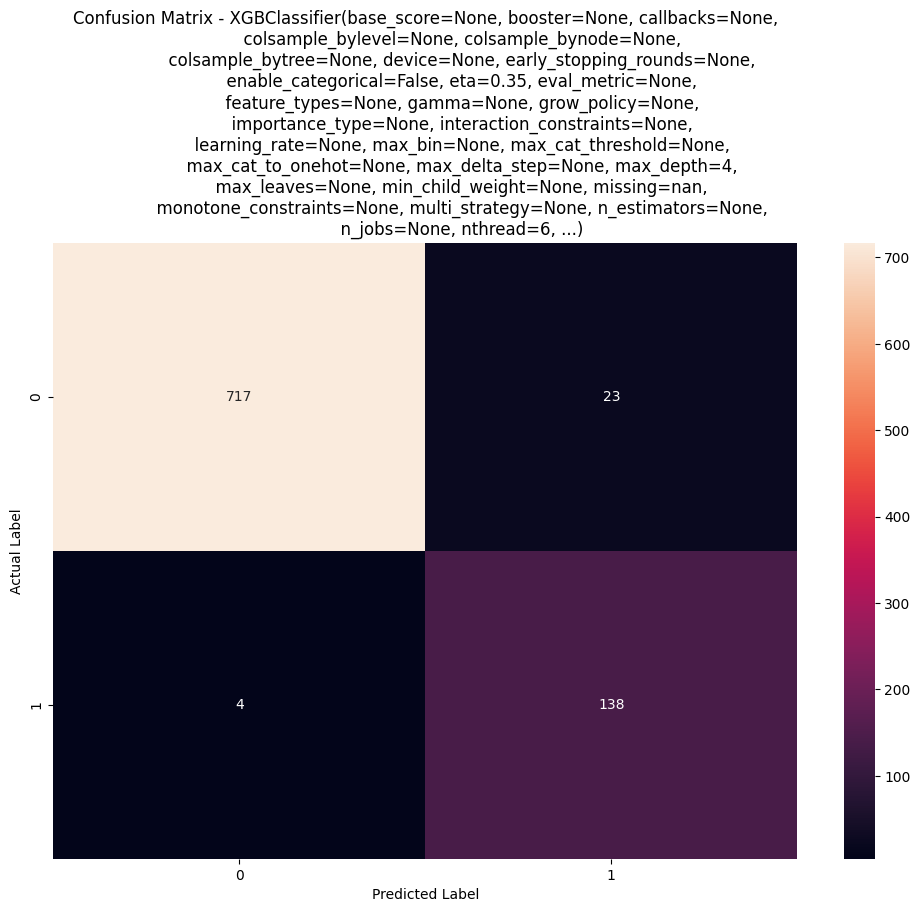

In [ ]:
confusion(xg)

##### **Feature Importance**

In [ ]:
# Mengeluarkan feature importance
feature_importance = xg.feature_importances_

# Menyusun hasil feature importance ke dalam DataFrame (opsional)
feature_importance_df = pd.DataFrame({
    'Feature': Xtrain_over.columns,
    'Importance': feature_importance
})

# Menampilkan feature importance secara terurut menurun
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                              Feature  Importance
40              MaritalStatus_Married    0.063395
39             MaritalStatus_Divorced    0.056702
18          BusinessTravel_Non-Travel    0.047536
34     JobRole_Manufacturing Director    0.045265
12               YearsWithCurrManager    0.039408
9               TrainingTimesLastYear    0.034815
22  Department_Research & Development    0.034439
3                            JobLevel    0.034025
29    EducationField_Technical Degree    0.033899
19   BusinessTravel_Travel_Frequently    0.032945
14                    JobSatisfaction    0.029859
31            JobRole_Human Resources    0.029415
20       BusinessTravel_Travel_Rarely    0.028701
23                   Department_Sales    0.028641
41               MaritalStatus_Single    0.027766
10                     YearsAtCompany    0.025465
42                      Gender_Female    0.022179
38       JobRole_Sales Representative    0.020902
30  JobRole_Healthcare Representative    0.020478


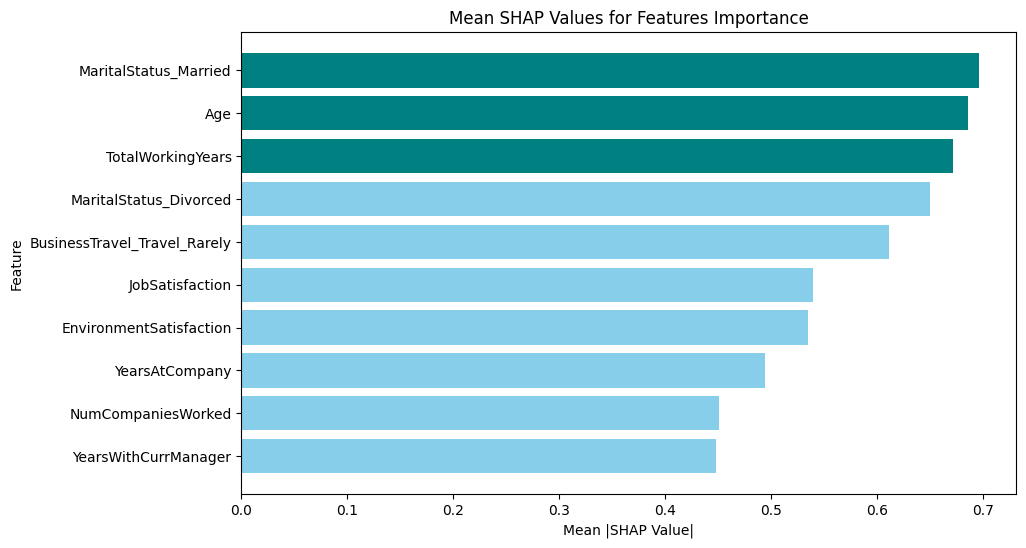

In [ ]:
# Latih model XGBoost
model = xgboost.XGBClassifier()
model.fit(Xtrain_over, ytrain_over)

# Hitung SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtest)

# Hitung mean SHAP values
mean_shap_values = abs(shap_values).mean(axis=0)

# Mengurutkan fitur berdasarkan nilai SHAP yang terkecil
sorted_indices = mean_shap_values.argsort()
sorted_mean_shap_values = mean_shap_values[sorted_indices]
sorted_features = Xtest.columns[sorted_indices]

# Batasi hanya 10 fitur teratas
top_10_features = sorted_features[-10:]
top_10_mean_shap_values = sorted_mean_shap_values[-10:]

# Plot bar SHAP dengan matplotlib
plt.figure(figsize=(10, 6))

# Plot barplot dengan warna merah untuk tiga fitur terbesar
color_map = ['skyblue'] * len(top_10_features)
color_map[-3:] = ['teal'] * 3  # Ubah warna tiga fitur terbesar menjadi merah

plt.barh(top_10_features, top_10_mean_shap_values, color=color_map)
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Features Importance')
plt.show()

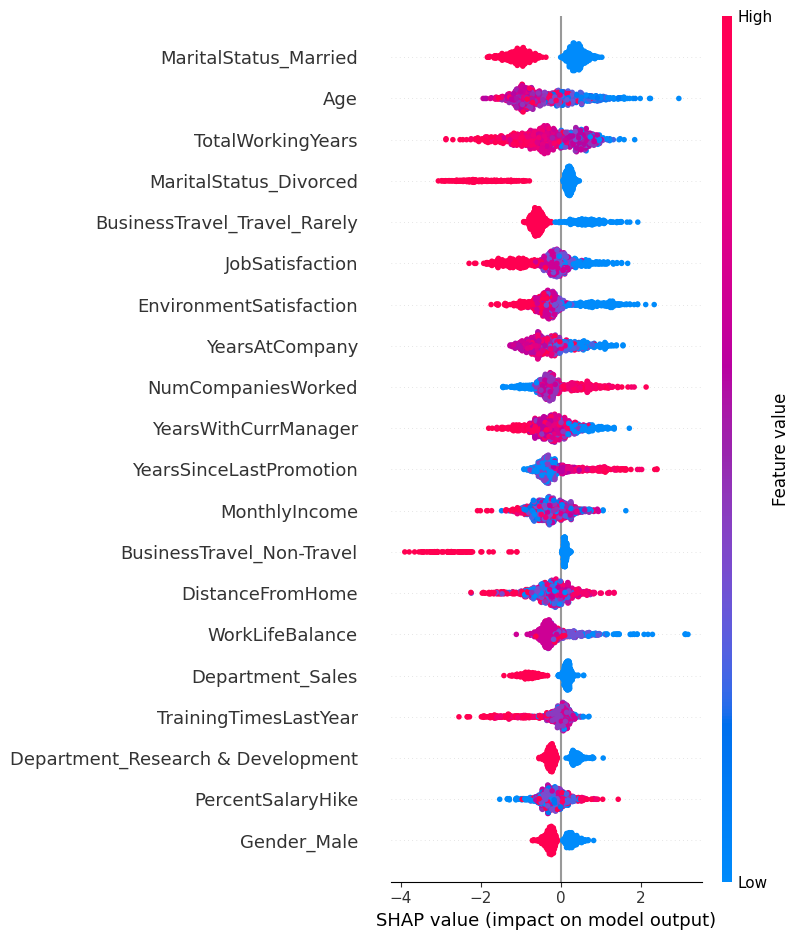

In [ ]:
model = xgboost.XGBClassifier()
model.fit(Xtrain_over, ytrain_over)

# Hitung SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(Xtest)

# Buat plot bar SHAP
shap.summary_plot(shap_values, Xtest)